<a href="https://colab.research.google.com/github/PhreshAda/My-work/blob/main/Diabetes_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 26.5 MB/s eta 0:00:00


In [2]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [62]:
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import shap
import joblib


In [5]:
# Load the dataset
df = pd.read_csv('/content/Group5_data.csv')

In [6]:
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12694 entries, 0 to 12693
Columns: 303 entries, X_STATE to X_VEGETE1
dtypes: float64(288), int64(15)
memory usage: 29.3 MB
None
            X_STATE        FMONTH         IDATE        IMONTH          IDAY  \
count  12694.000000  12694.000000  1.269400e+04  12694.000000  12694.000000   
mean       2.050733      6.406570  6.680719e+06      6.527966     15.073184   
std        1.087568      3.468791  3.383205e+06      3.388516      8.569995   
min        1.000000      1.000000  1.012022e+06      1.000000      1.000000   
25%        1.000000      3.000000  4.012021e+06      4.000000      8.000000   
50%        2.000000      6.000000  7.082021e+06      7.000000     15.000000   
75%        2.000000      9.000000  9.242021e+06      9.000000     22.000000   
max        4.000000     12.000000  1.231202e+07     12.000000     31.000000   

              IYEAR      DISPCODE         SEQNO         X_PSU  CTELENM1  ...  \
count  12694.000000  12694.000

In [7]:
# List of identified relevant features
selected_features = ['SEXVAR', 'GENHLTH', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EXERANY2', 'BPMEDS', 'CHOLCHK3', 'TOLDHI3',
'CHOLMED3', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'CHCKDNY2', 'DIABETE4', 'EDUCA', 'VETERAN3', 'EMPLOY1', 'INCOME3', 'PREGNANT',
'BLIND', 'PDIABTST', 'PREDIAB1', 'X_RFHLTH', 'X_PHYS14D', 'X_MENT14D', 'X_RFHYPE6', 'X_RFCHOL3', 'X_MICHD', 'X_RACE',
 'X_AGEG5YR', 'X_BMI5CAT', 'X_EDUCAG', 'X_INCOMG1', 'X_SMOKER3', 'DRNKANY5', 'X_RFSMOK3', 'X_RFDRHV7', 'GRENDA1_',
   'FRNCHDA_', 'POTADA1_', 'VEGEDA2_', 'X_FRUTSU1', 'X_VEGESU1']  # Update with actual features
df = df[selected_features]


In [8]:
# Import SimpleImputer
from sklearn.impute import SimpleImputer

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(df.values) # Assuming you want to impute on all of df

In [9]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values if necessary
df.fillna(df.median(), inplace=True)

SEXVAR           0
GENHLTH          1
PERSDOC3         2
MEDCOST1         2
CHECKUP1         2
EXERANY2         2
BPMEDS        7205
CHOLCHK3         2
TOLDHI3       1702
CHOLMED3      1702
CVDINFR4         2
CVDCRHD4         2
CVDSTRK3         2
CHCKDNY2         2
DIABETE4         2
EDUCA            2
VETERAN3        41
EMPLOY1         83
INCOME3        181
PREGNANT     10633
BLIND          381
PDIABTST      9111
PREDIAB1      9110
X_RFHLTH         1
X_PHYS14D        1
X_MENT14D        1
X_RFHYPE6        1
X_RFCHOL3     1703
X_MICHD        123
X_RACE           1
X_AGEG5YR        1
X_BMI5CAT     1050
X_EDUCAG         1
X_INCOMG1        1
X_SMOKER3        1
DRNKANY5         1
X_RFSMOK3        1
X_RFDRHV7        1
GRENDA1_      1111
FRNCHDA_      1126
POTADA1_      1210
VEGEDA2_      1233
X_FRUTSU1     1296
X_VEGESU1     1552
dtype: int64


In [10]:
# Fill missing values with the median for each column
df.fillna(df.median(), inplace=True)

# Verify that there are no missing values remaining
print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 SEXVAR       0
GENHLTH      0
PERSDOC3     0
MEDCOST1     0
CHECKUP1     0
EXERANY2     0
BPMEDS       0
CHOLCHK3     0
TOLDHI3      0
CHOLMED3     0
CVDINFR4     0
CVDCRHD4     0
CVDSTRK3     0
CHCKDNY2     0
DIABETE4     0
EDUCA        0
VETERAN3     0
EMPLOY1      0
INCOME3      0
PREGNANT     0
BLIND        0
PDIABTST     0
PREDIAB1     0
X_RFHLTH     0
X_PHYS14D    0
X_MENT14D    0
X_RFHYPE6    0
X_RFCHOL3    0
X_MICHD      0
X_RACE       0
X_AGEG5YR    0
X_BMI5CAT    0
X_EDUCAG     0
X_INCOMG1    0
X_SMOKER3    0
DRNKANY5     0
X_RFSMOK3    0
X_RFDRHV7    0
GRENDA1_     0
FRNCHDA_     0
POTADA1_     0
VEGEDA2_     0
X_FRUTSU1    0
X_VEGESU1    0
dtype: int64


In [11]:
# Mapping the target variable
# 1 and 2 will be mapped to 1 (yes)
# 3 and 4 will be mapped to 0 (no)
df['diabete4_binary'] = df['DIABETE4'].map({1: 1, 2: 1, 3: 0, 4: 0})

# Verify the mapping
print(df['diabete4_binary'].value_counts())

diabete4_binary
0.0    10789
1.0     1882
Name: count, dtype: int64


In [12]:
# Check for missing values in the transformed target variable
print(df['diabete4_binary'].isnull().sum())

23


In [13]:
# Display rows where the target variable is missing
missing_data = df[df['diabete4_binary'].isnull()]
print(missing_data.head())

      SEXVAR  GENHLTH  PERSDOC3  MEDCOST1  CHECKUP1  EXERANY2  BPMEDS  \
1181       2      4.0       1.0       2.0       1.0       2.0     1.0   
2679       1      4.0       1.0       2.0       1.0       2.0     1.0   
3634       2      4.0       2.0       1.0       2.0       2.0     1.0   
4201       1      3.0       3.0       2.0       7.0       1.0     1.0   
4632       1      2.0       1.0       2.0       1.0       9.0     1.0   

      CHOLCHK3  TOLDHI3  CHOLMED3  ...  DRNKANY5  X_RFSMOK3  X_RFDRHV7  \
1181       1.0      2.0       2.0  ...       2.0        2.0        1.0   
2679       2.0      1.0       1.0  ...       1.0        1.0        1.0   
3634       2.0      9.0       2.0  ...       2.0        1.0        1.0   
4201       7.0      2.0       2.0  ...       9.0        9.0        9.0   
4632       9.0      2.0       2.0  ...       9.0        9.0        9.0   

      GRENDA1_  FRNCHDA_  POTADA1_  VEGEDA2_  X_FRUTSU1  X_VEGESU1  \
1181       7.0       0.0      10.0     100.0  

In [14]:
# Remove rows where the target variable 'diabete4_binary' is NaN
df_cleaned = df.dropna(subset=['diabete4_binary'])

# Verify that the missing values are removed
print(df_cleaned['diabete4_binary'].isnull().sum())  # Should print 0

0


In [15]:
# Check if the new column has been created
print(df.columns)

Index(['SEXVAR', 'GENHLTH', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EXERANY2',
       'BPMEDS', 'CHOLCHK3', 'TOLDHI3', 'CHOLMED3', 'CVDINFR4', 'CVDCRHD4',
       'CVDSTRK3', 'CHCKDNY2', 'DIABETE4', 'EDUCA', 'VETERAN3', 'EMPLOY1',
       'INCOME3', 'PREGNANT', 'BLIND', 'PDIABTST', 'PREDIAB1', 'X_RFHLTH',
       'X_PHYS14D', 'X_MENT14D', 'X_RFHYPE6', 'X_RFCHOL3', 'X_MICHD', 'X_RACE',
       'X_AGEG5YR', 'X_BMI5CAT', 'X_EDUCAG', 'X_INCOMG1', 'X_SMOKER3',
       'DRNKANY5', 'X_RFSMOK3', 'X_RFDRHV7', 'GRENDA1_', 'FRNCHDA_',
       'POTADA1_', 'VEGEDA2_', 'X_FRUTSU1', 'X_VEGESU1', 'diabete4_binary'],
      dtype='object')


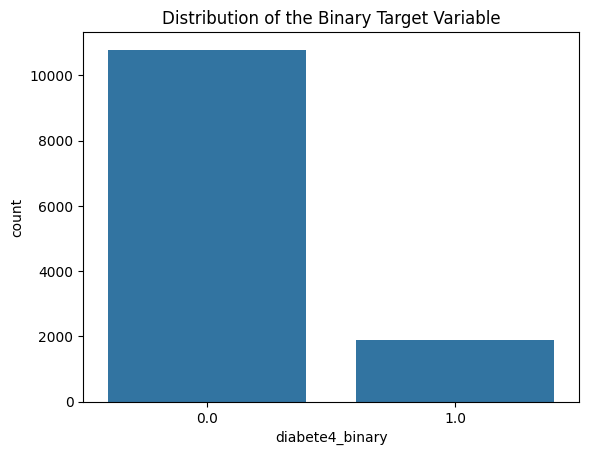

In [17]:
# Distribution of the target variable

sns.countplot(x='diabete4_binary', data=df)
plt.title('Distribution of the Binary Target Variable')
plt.show()

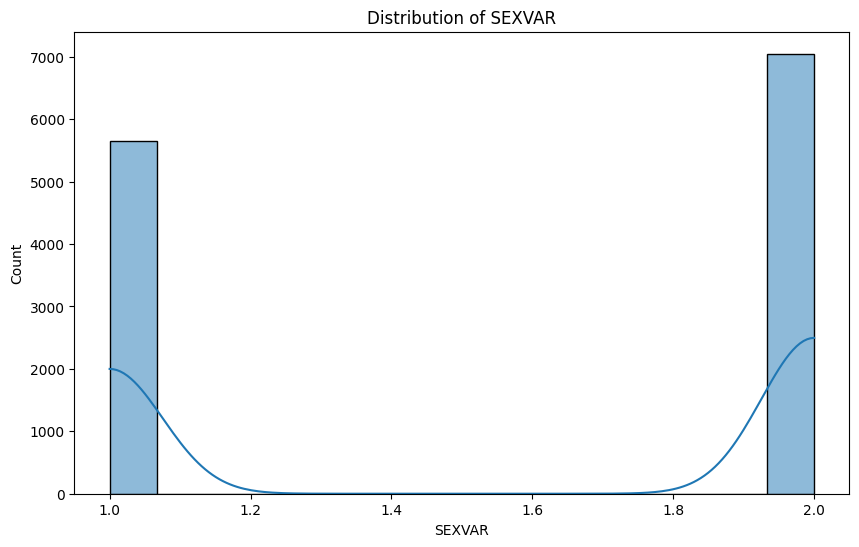

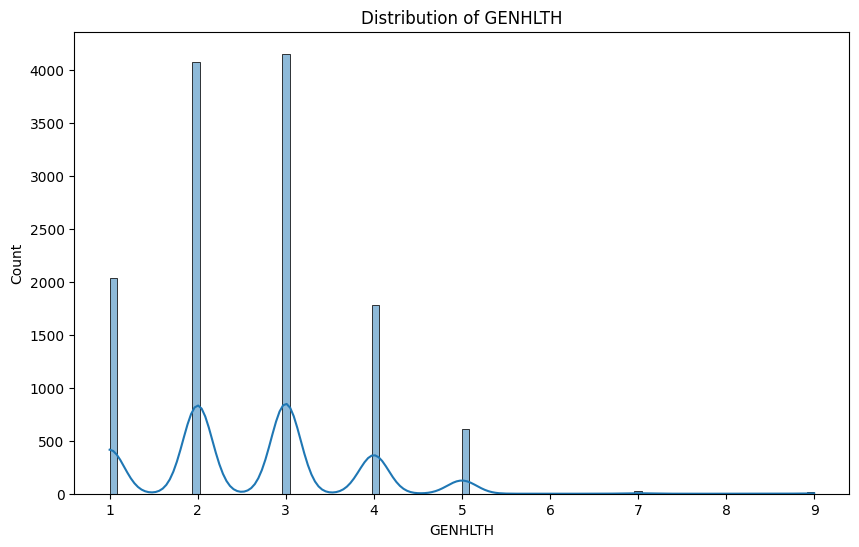

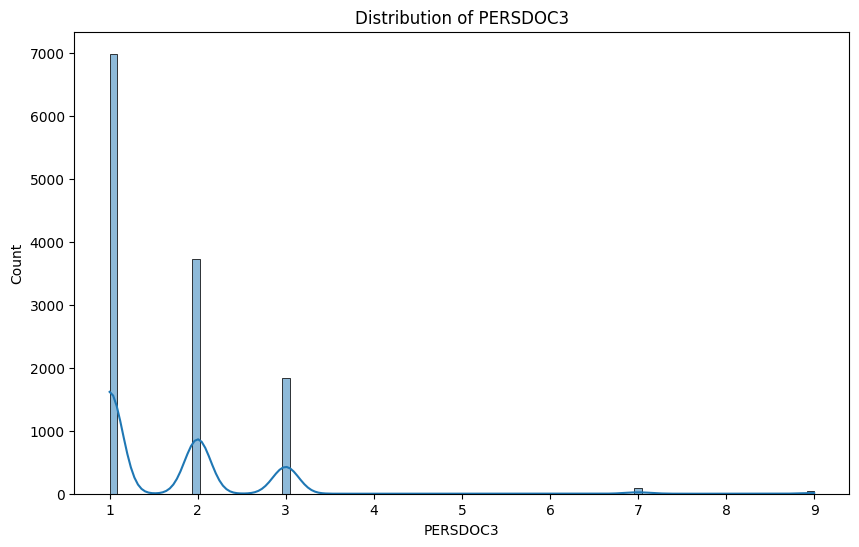

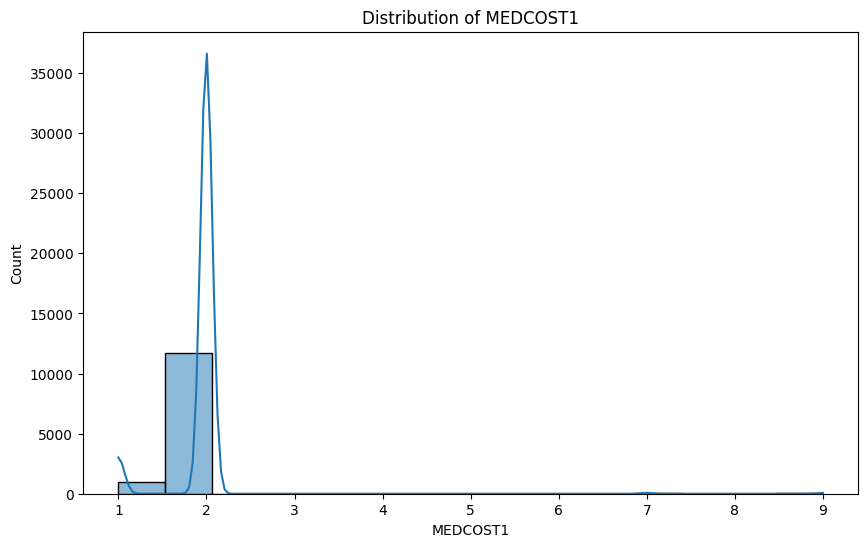

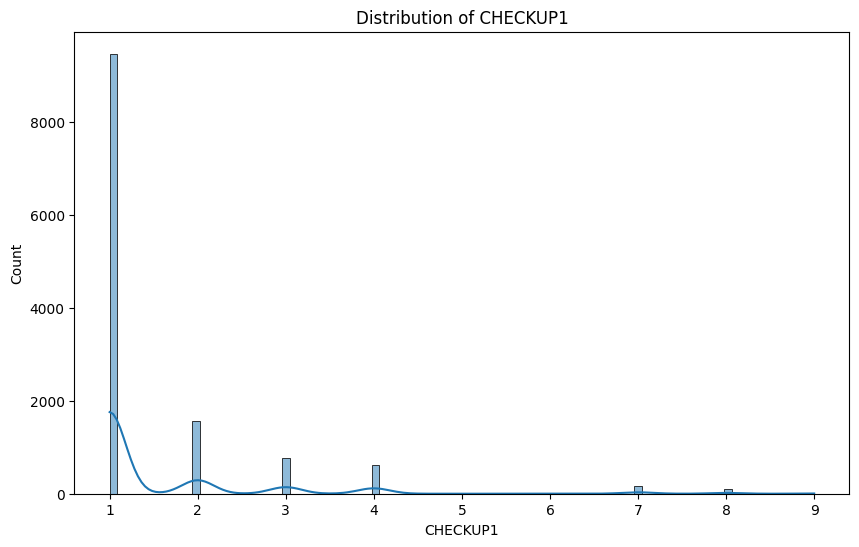

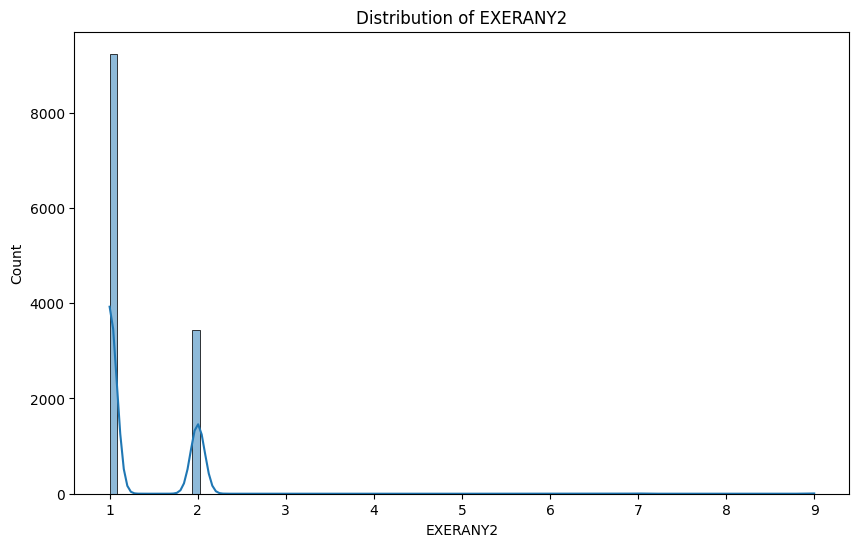

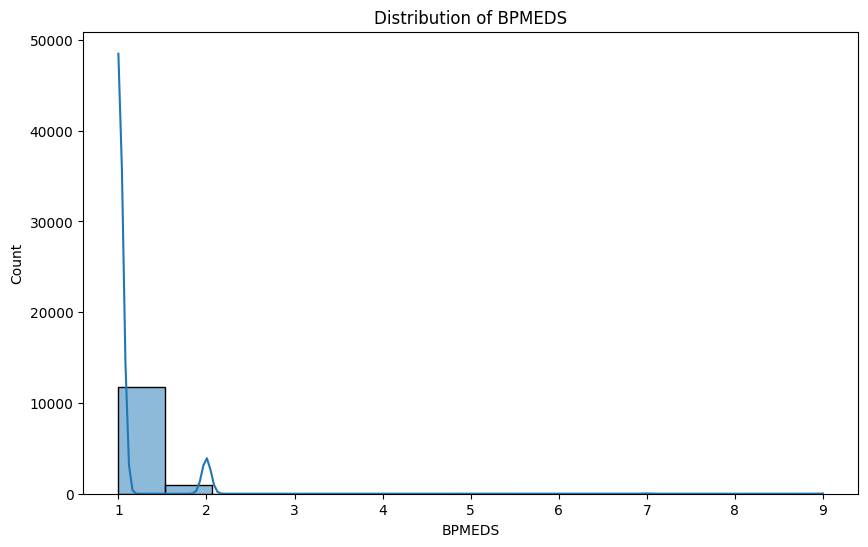

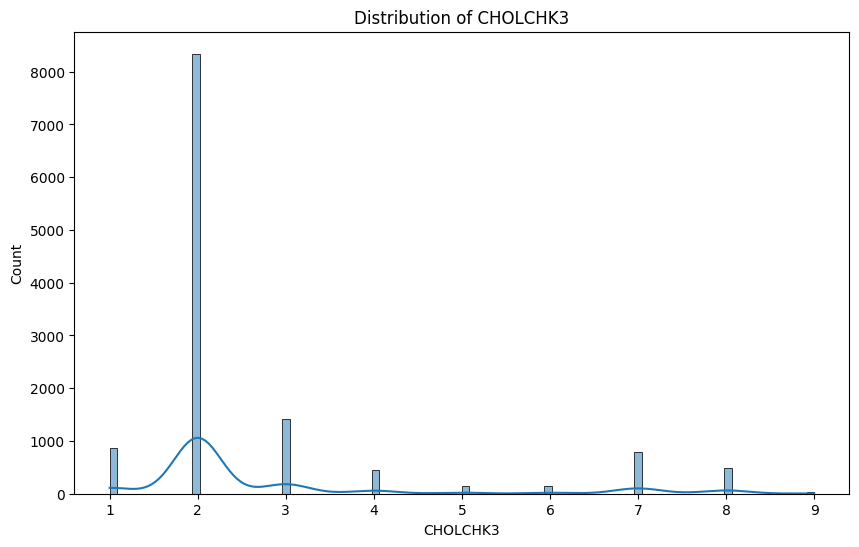

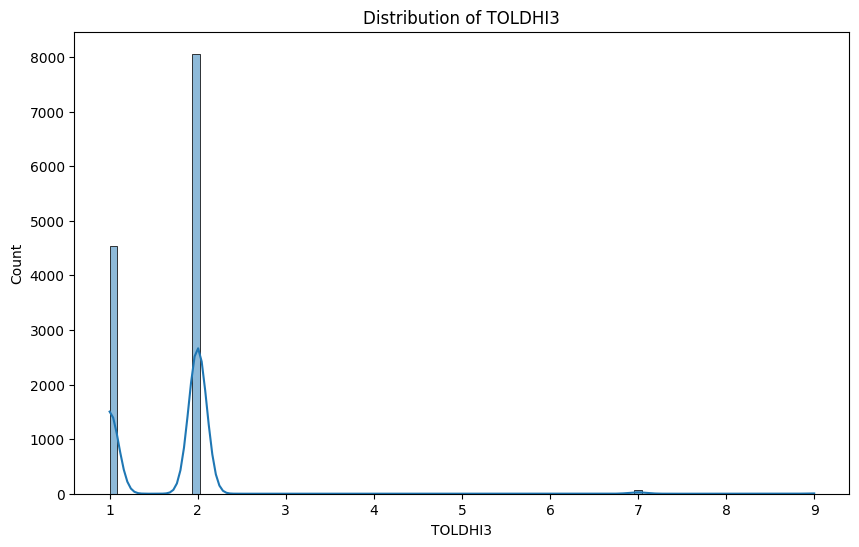

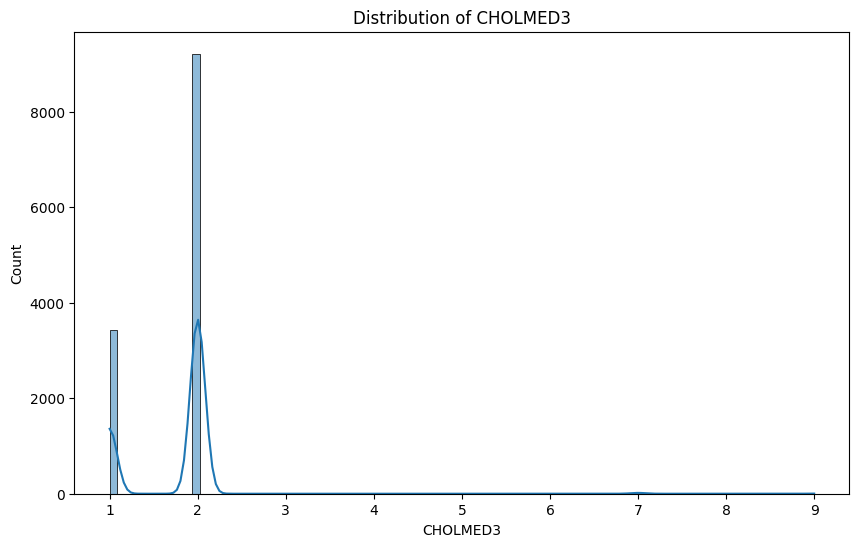

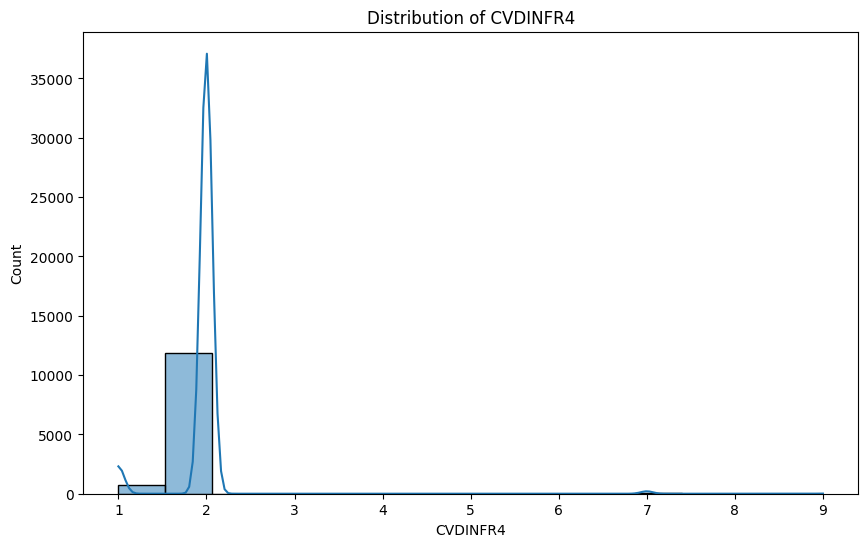

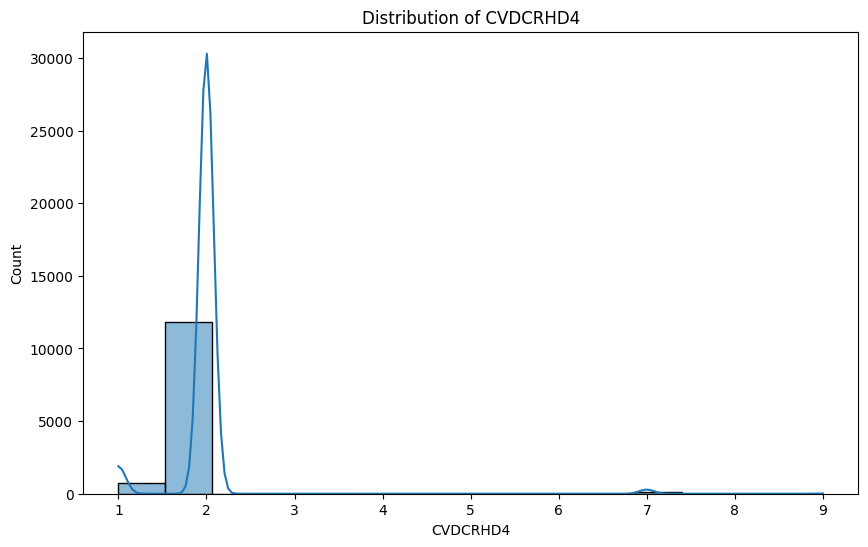

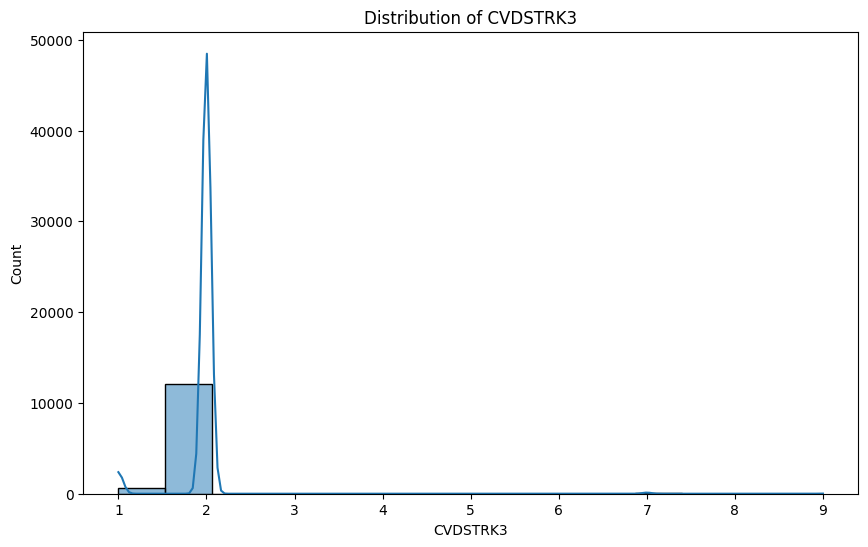

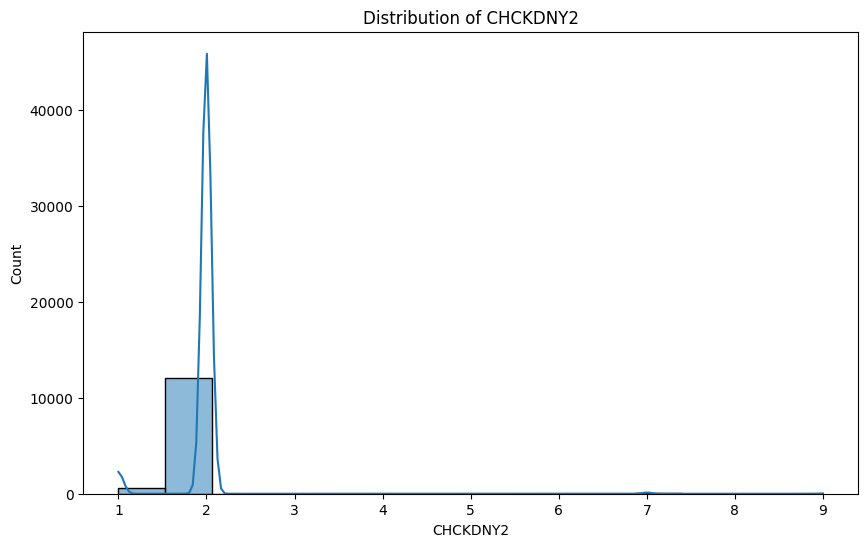

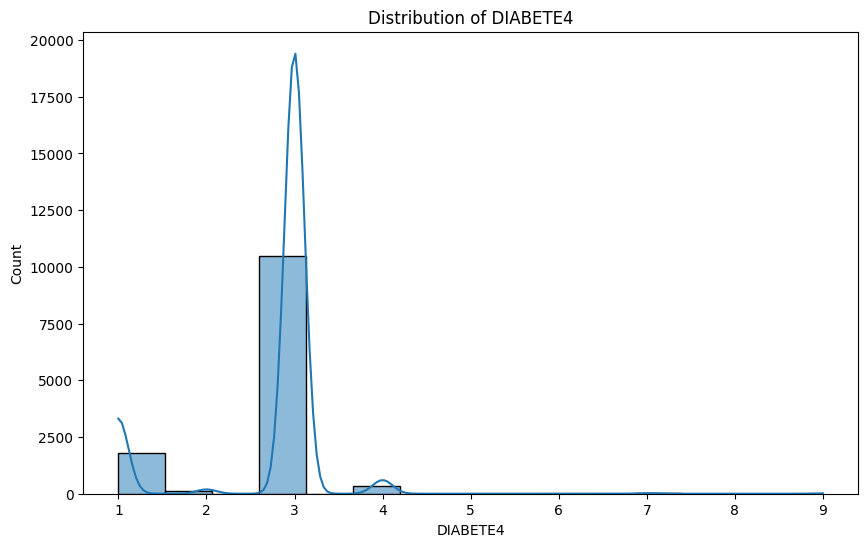

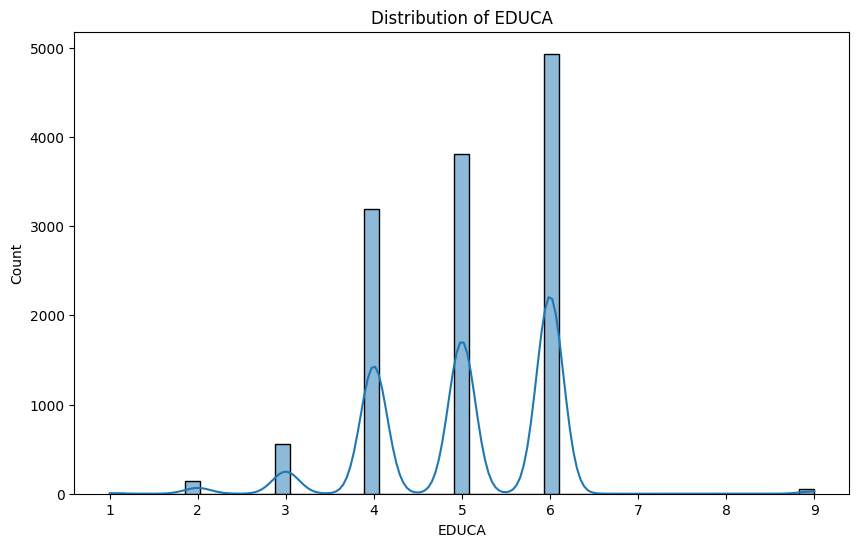

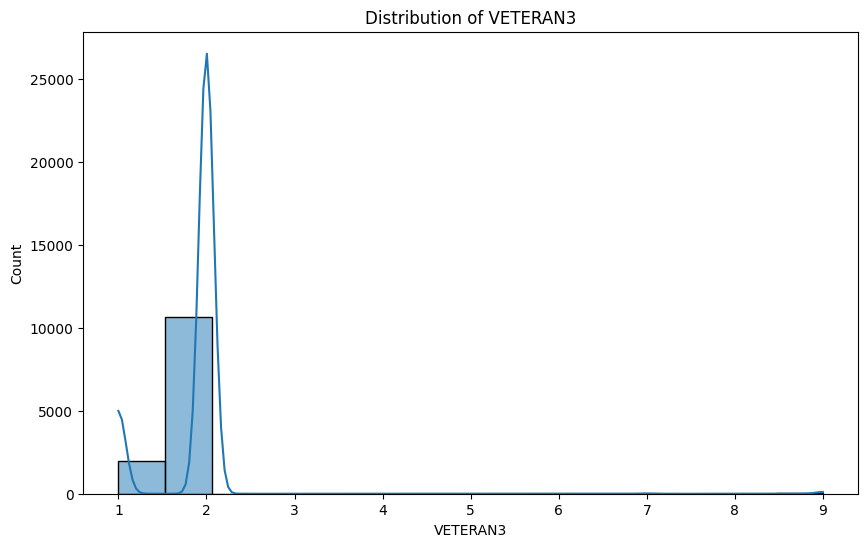

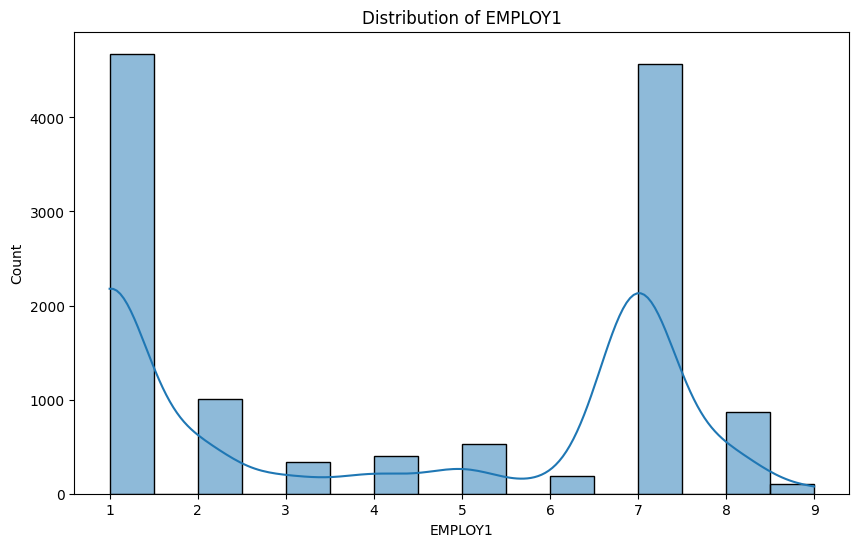

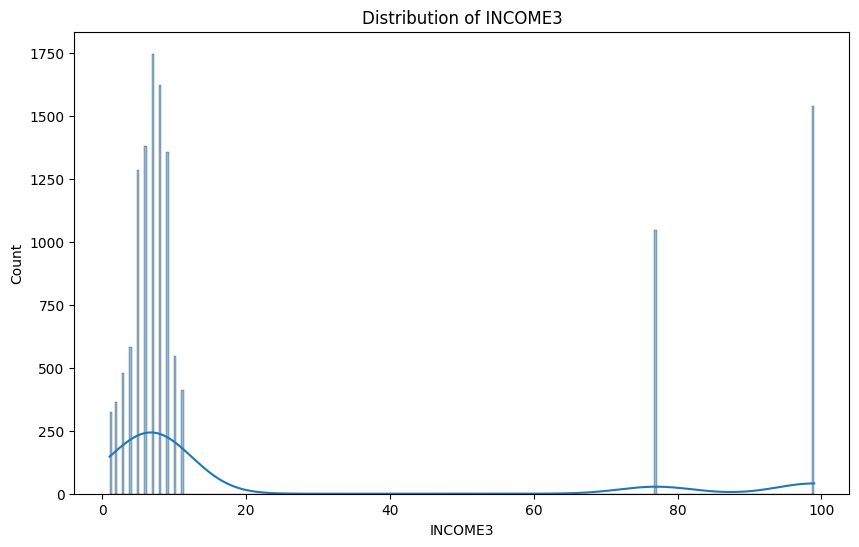

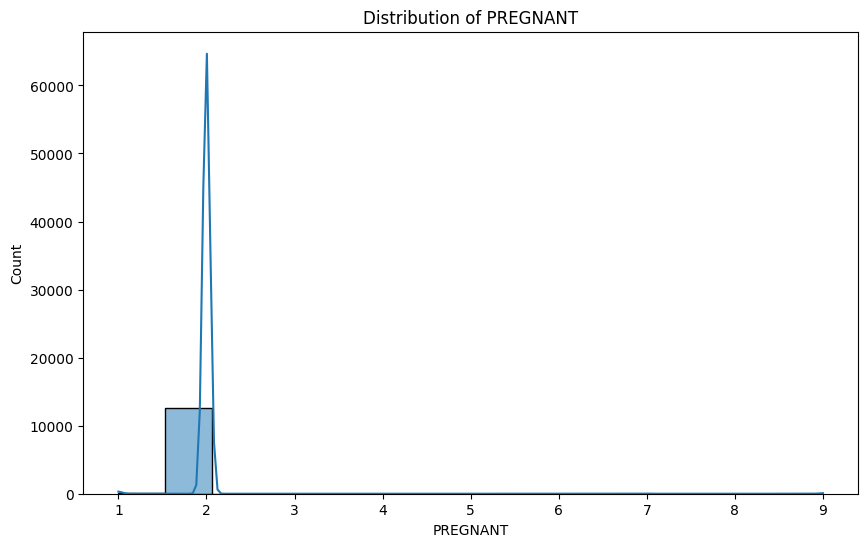

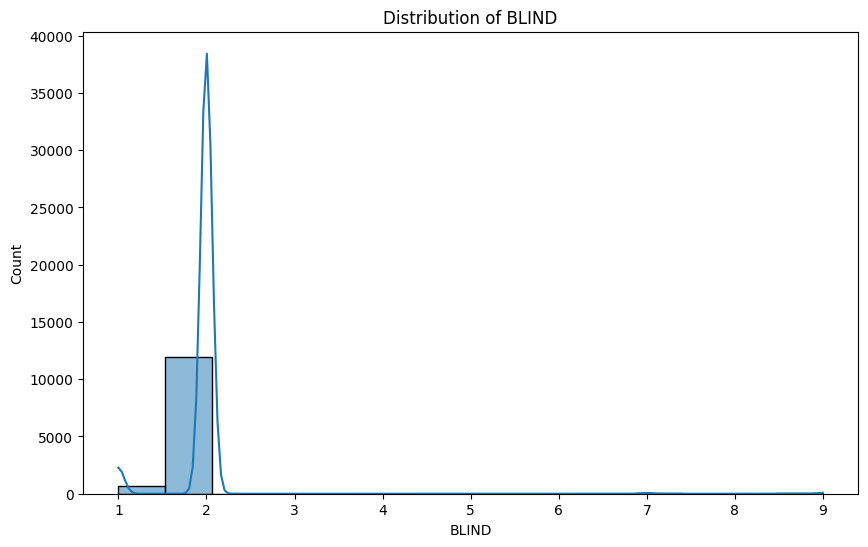

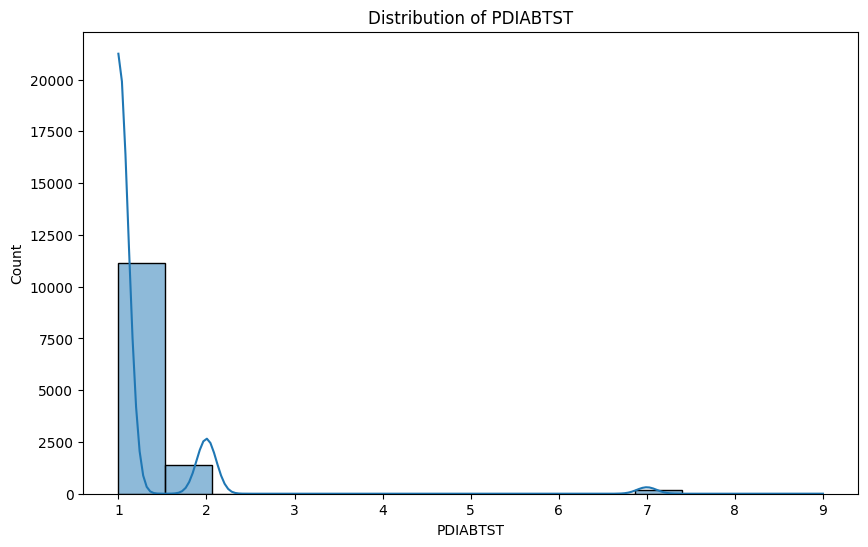

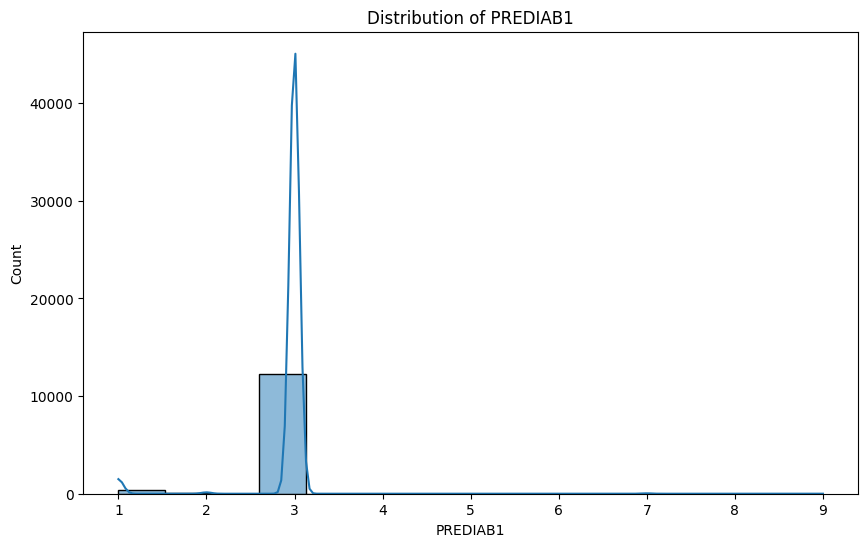

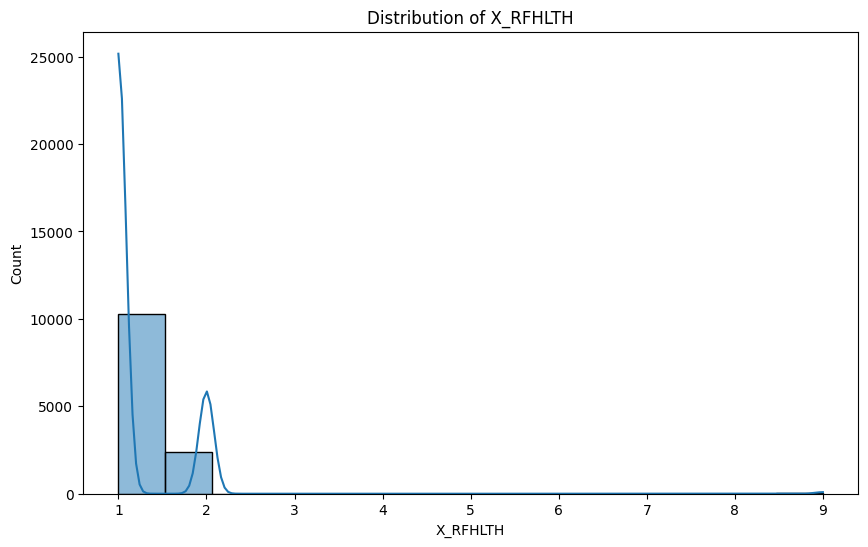

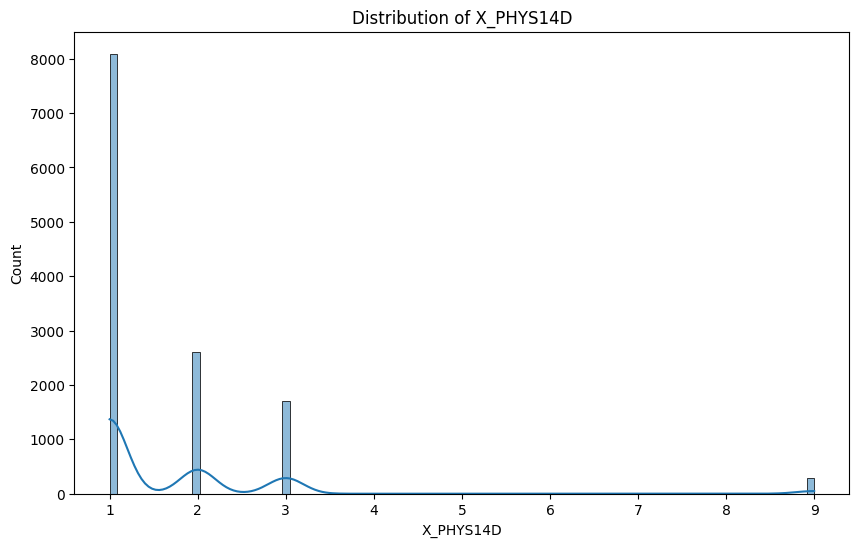

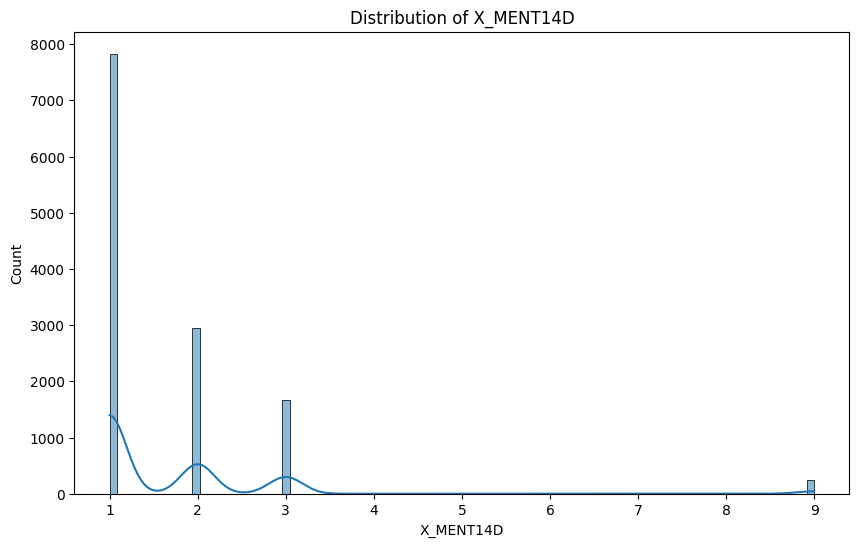

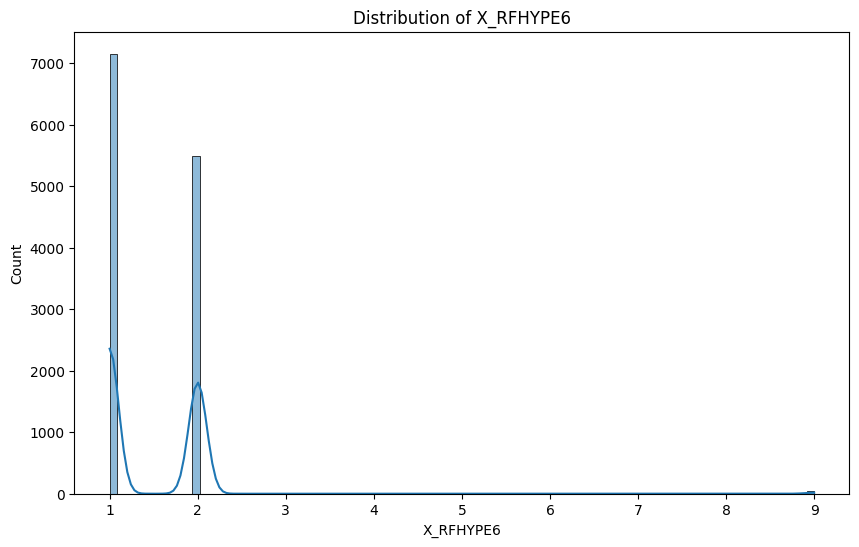

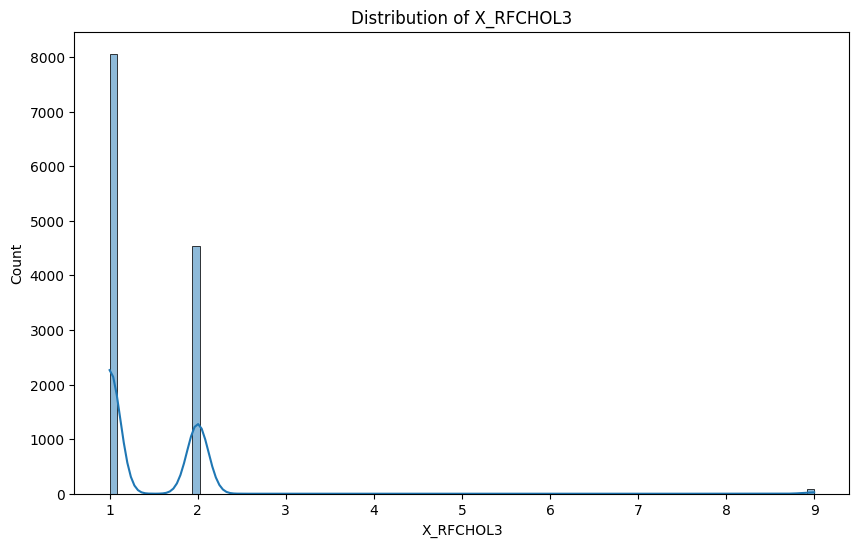

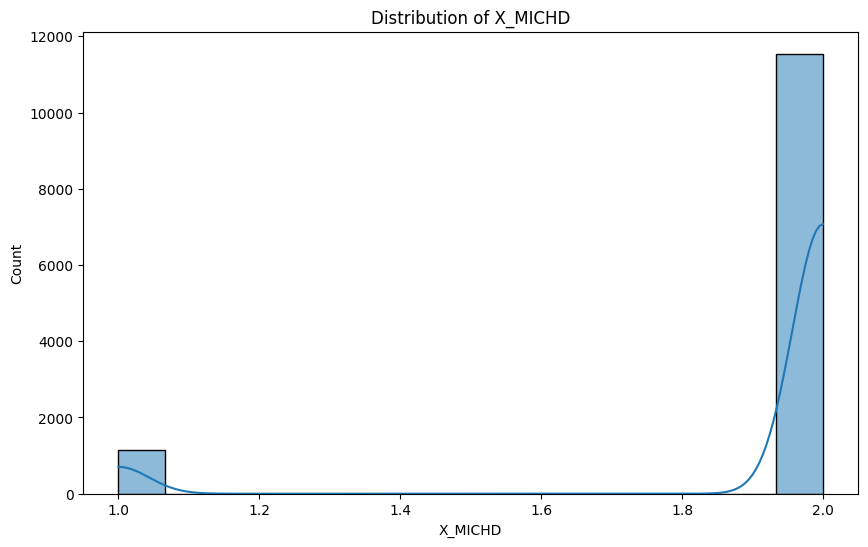

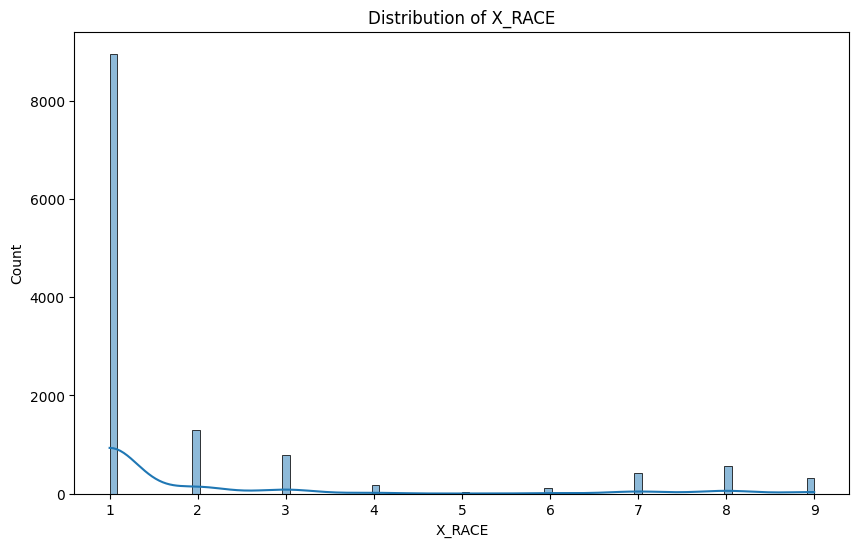

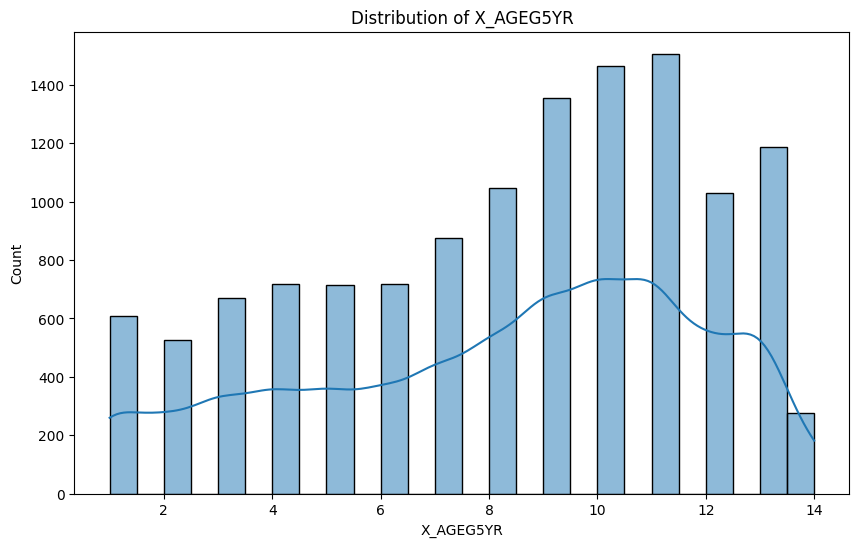

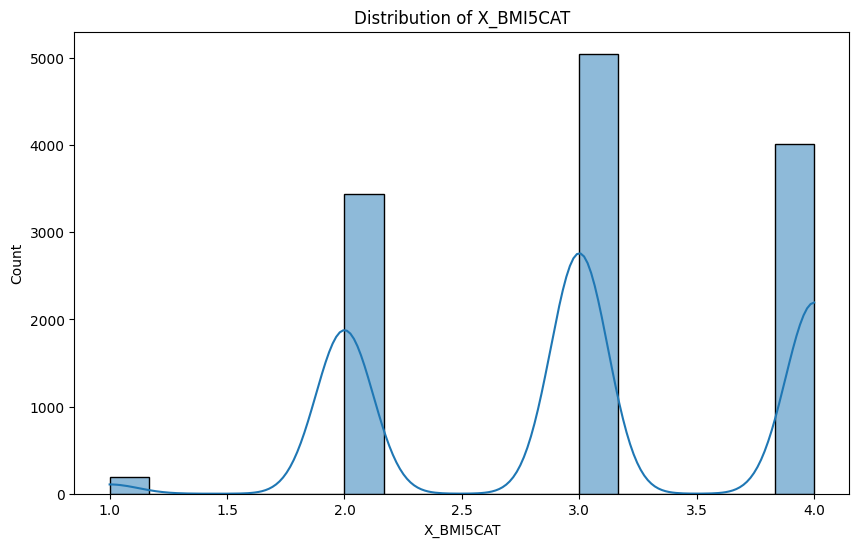

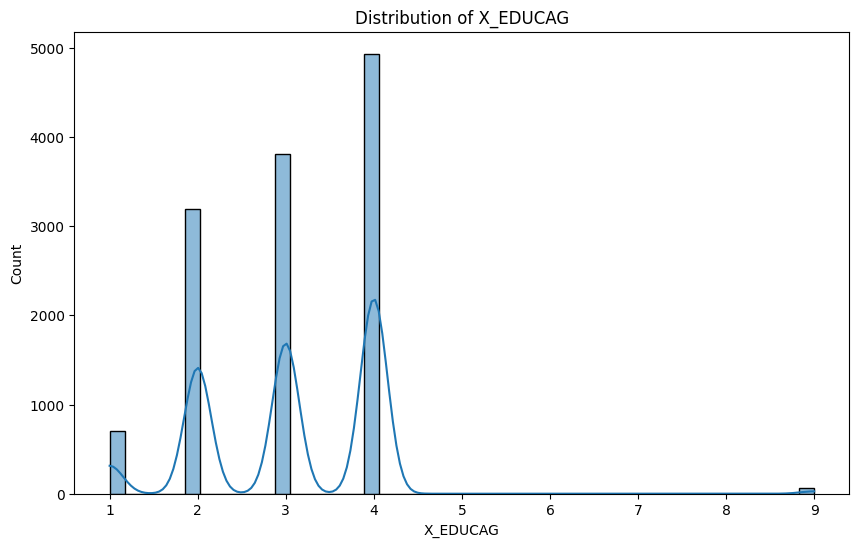

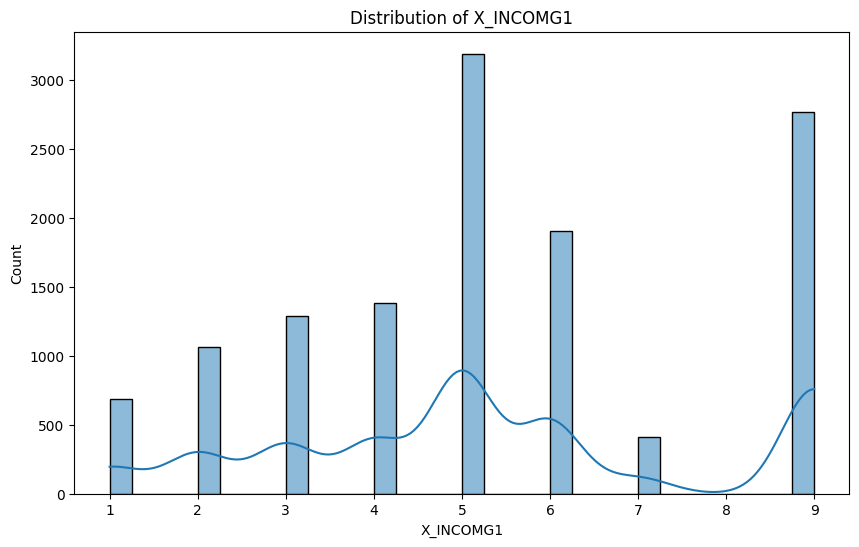

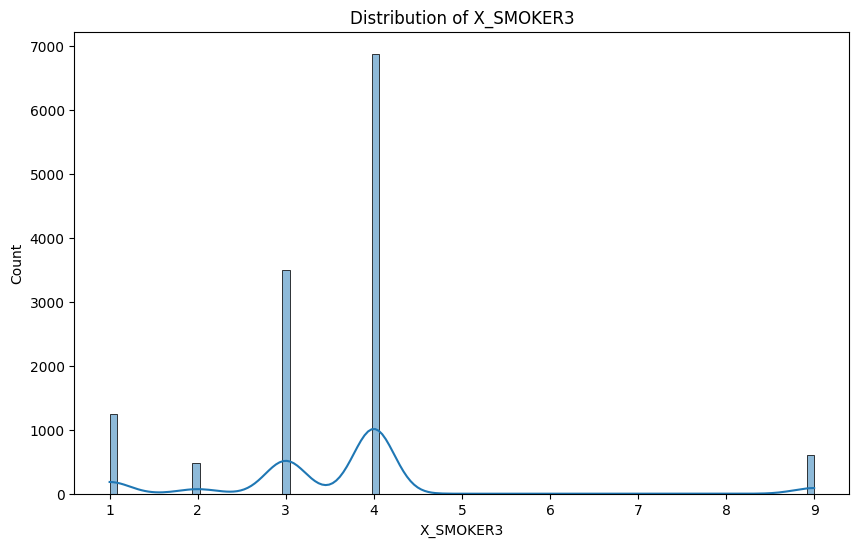

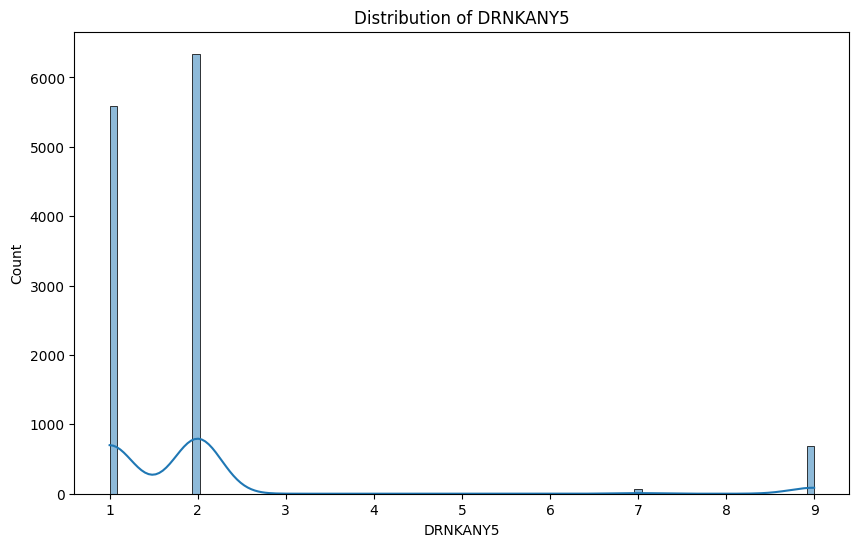

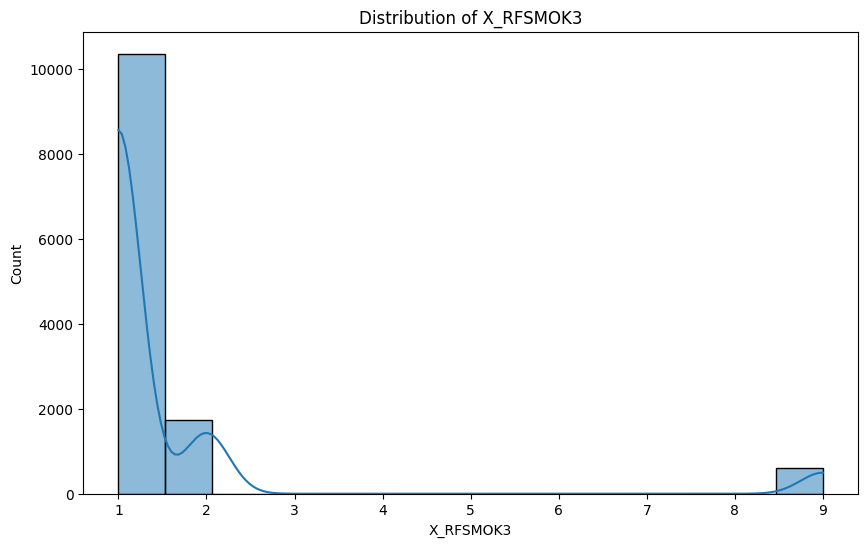

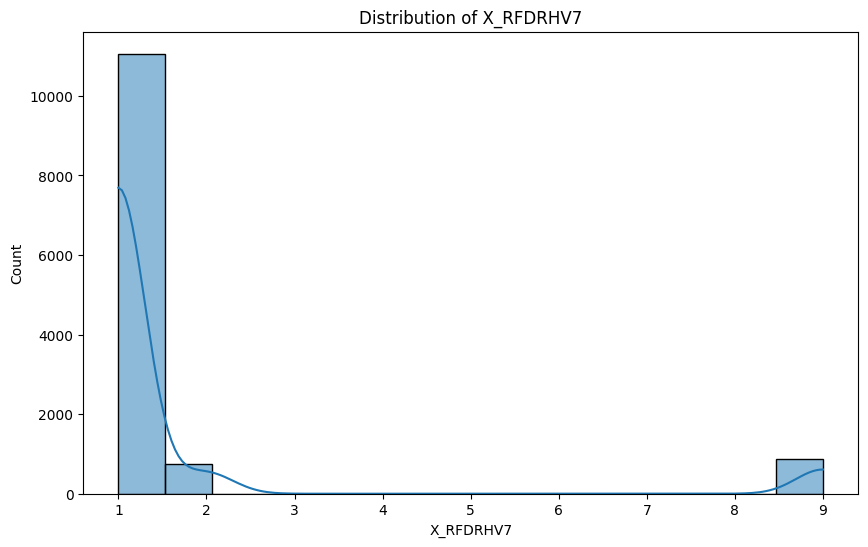

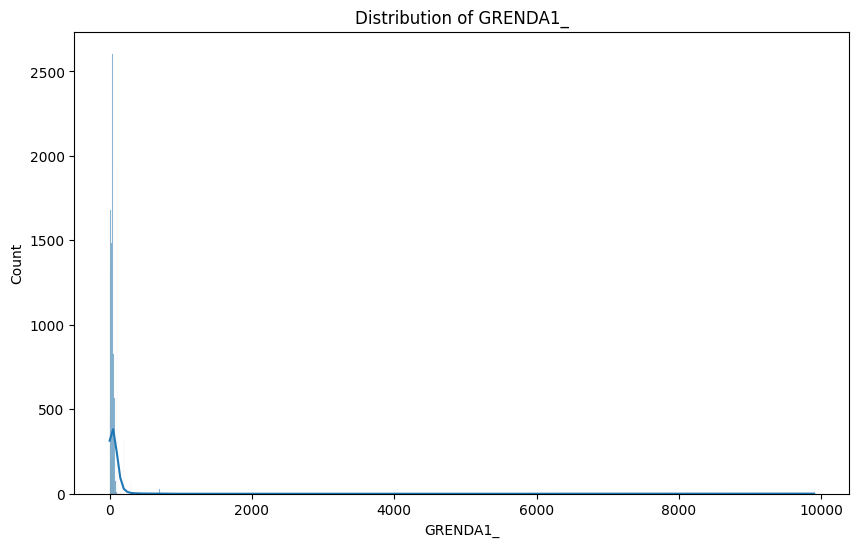

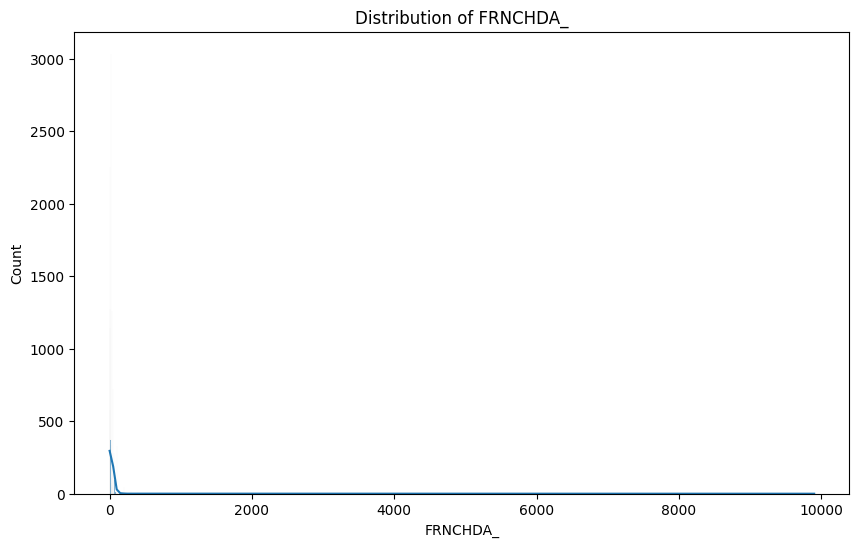

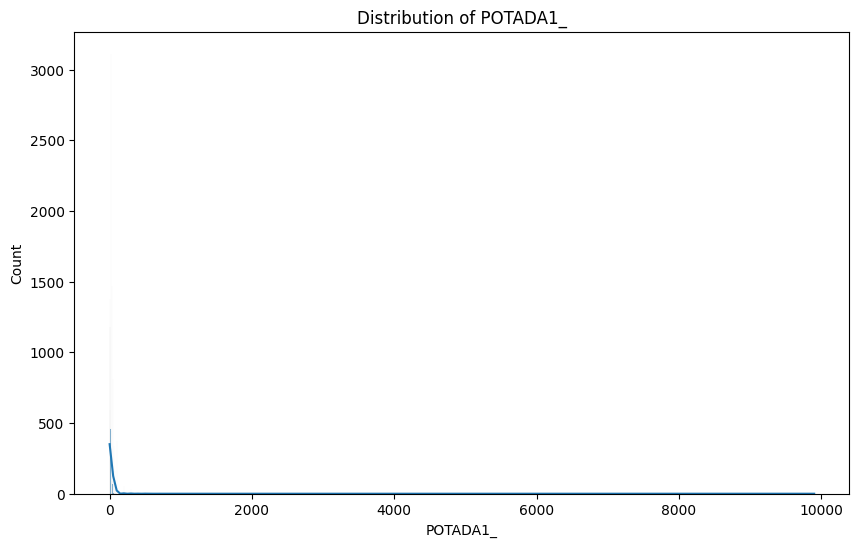

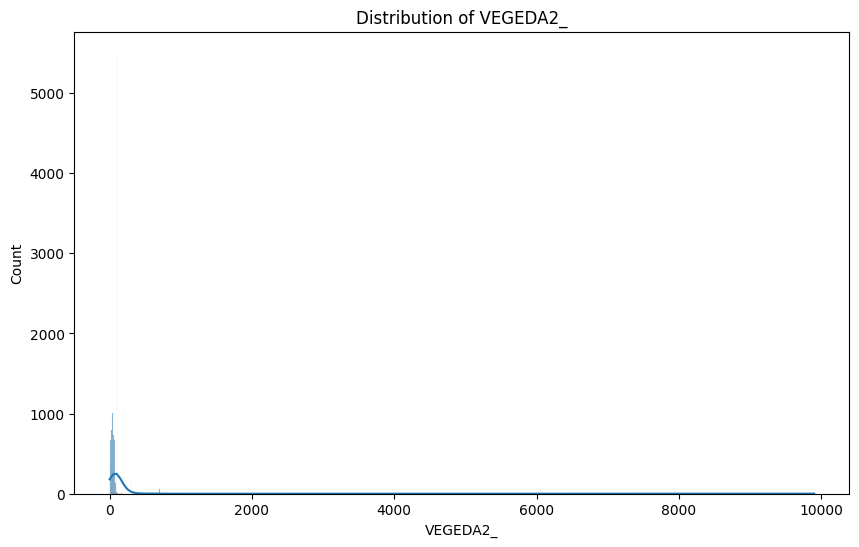

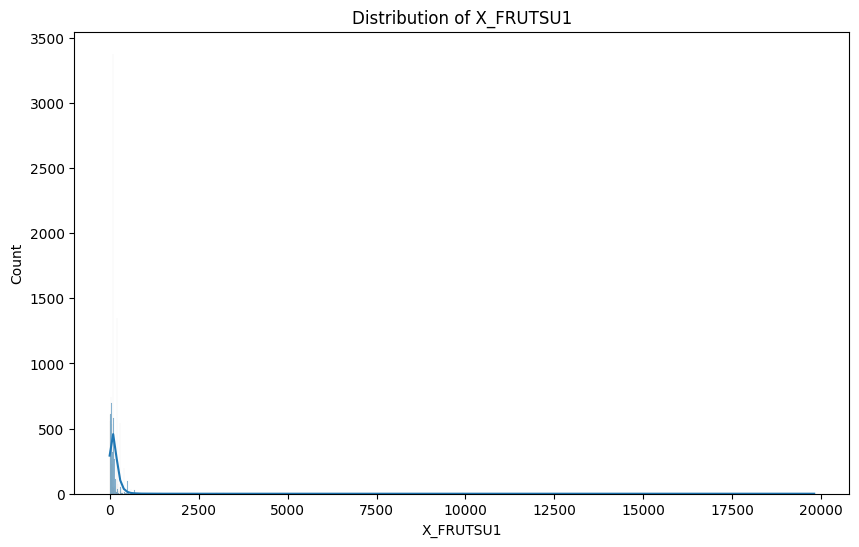

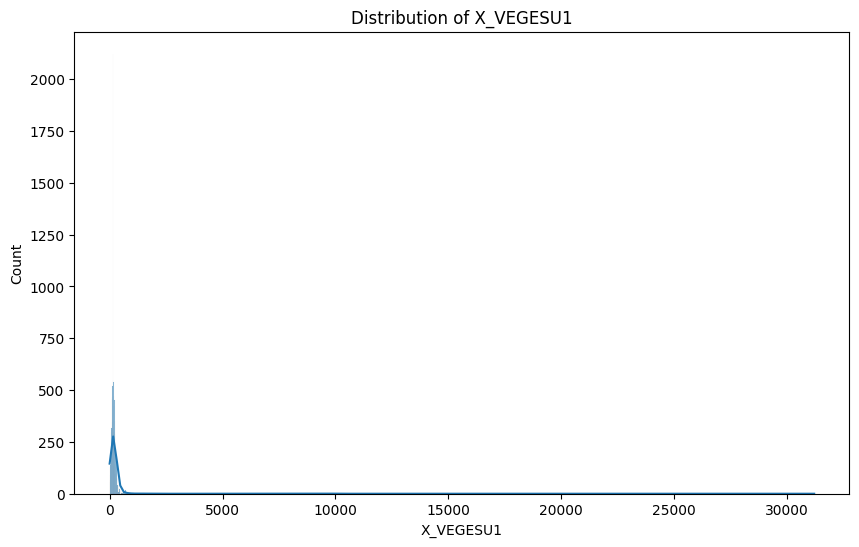

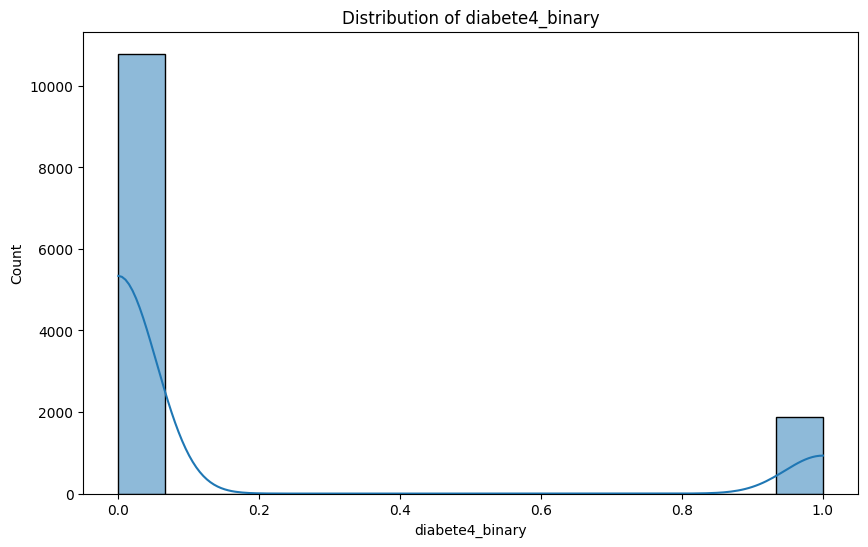

In [18]:
for column in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

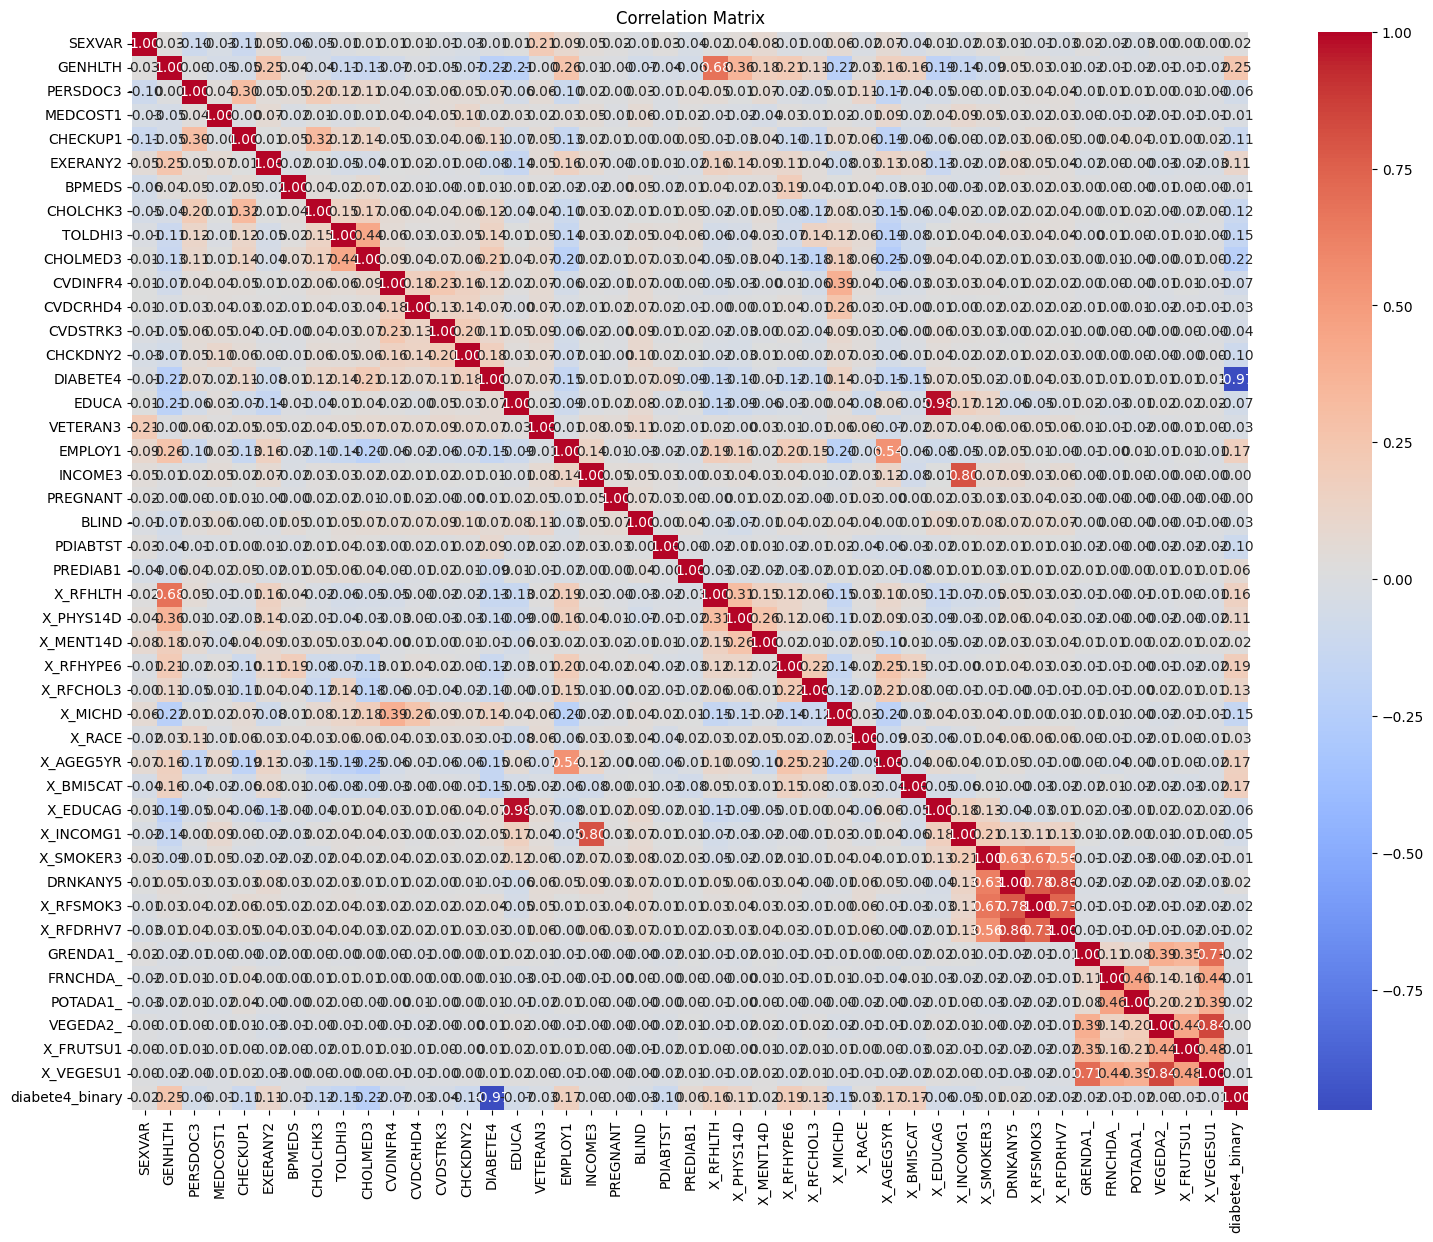

In [19]:
plt.figure(figsize=(18, 14))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

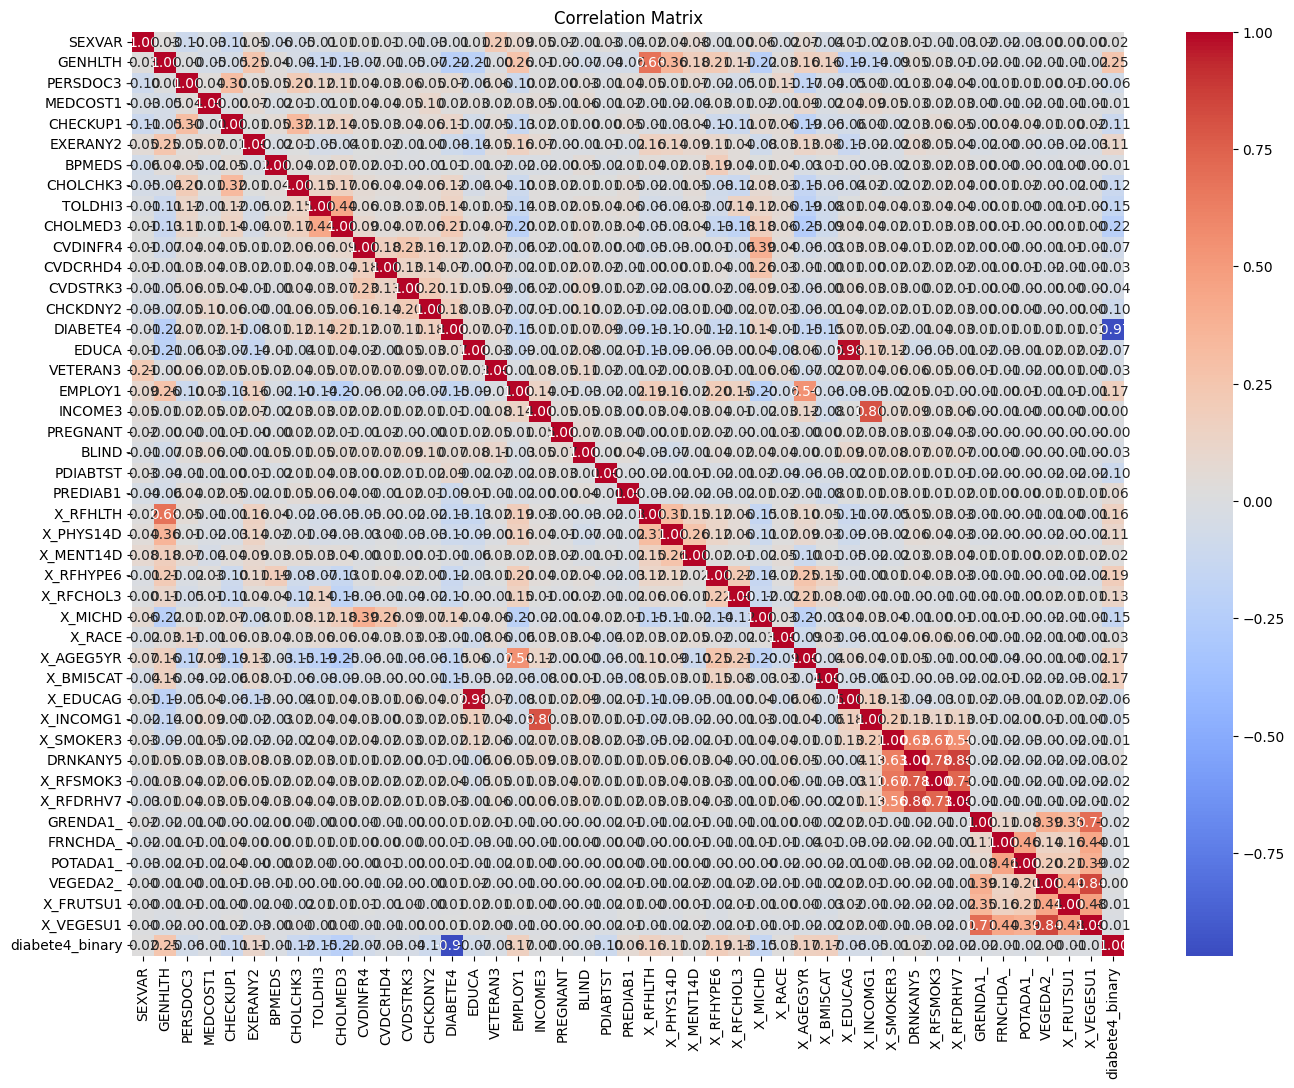

In [20]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

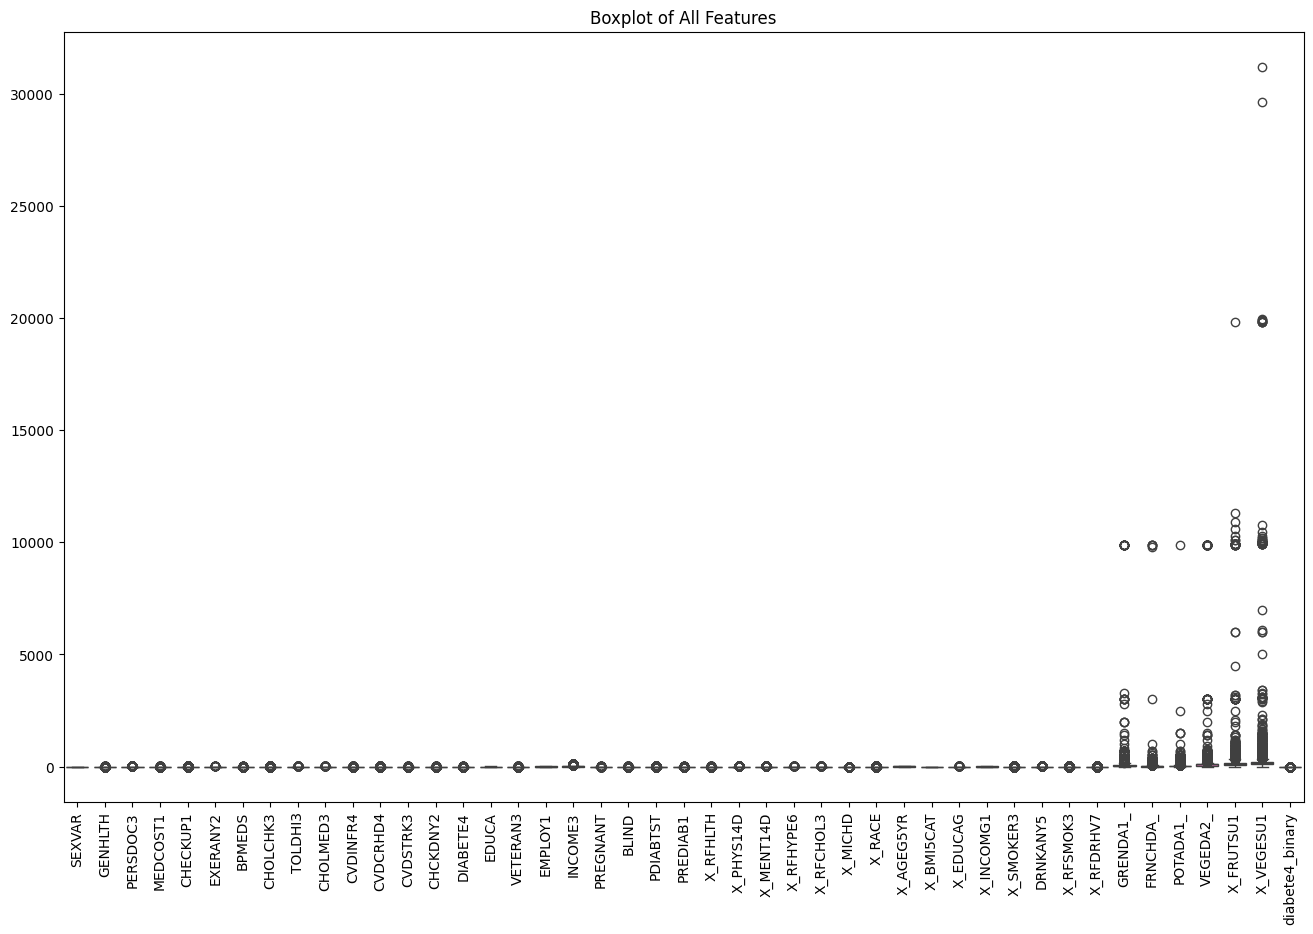

In [21]:
plt.figure(figsize=(16, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Boxplot of All Features')
plt.show()

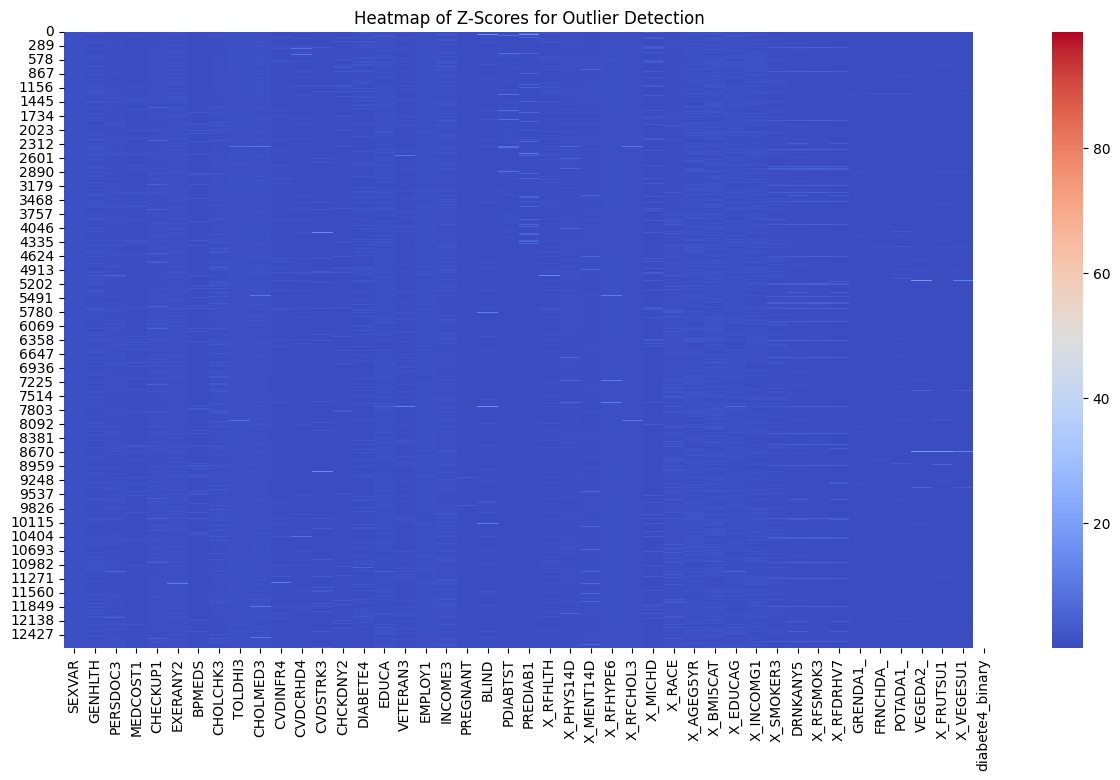

In [22]:
from scipy import stats
import numpy as np

# Calculate Z-scores
z_scores = np.abs(stats.zscore(df))

# Plot heatmap of Z-scores
plt.figure(figsize=(15, 8))
sns.heatmap(z_scores, cmap='coolwarm', annot=False)
plt.title('Heatmap of Z-Scores for Outlier Detection')
plt.show()


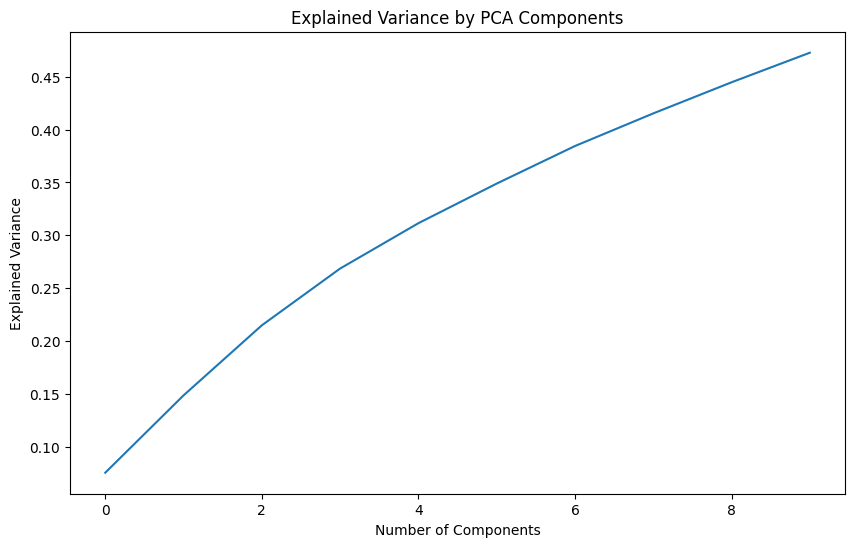

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=10)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()


In [28]:
# Drop columns that are not in the selected_columns list
df_filtered = df[selected_features]

# If you prefer to modify the original DataFrame:
df.drop(columns=[col for col in df.columns if col not in selected_features], inplace=True)

# Verify the remaining columns
print(df.columns)  # or print(df_filtered.columns)

Index(['SEXVAR', 'GENHLTH', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EXERANY2',
       'BPMEDS', 'CHOLCHK3', 'TOLDHI3', 'CHOLMED3', 'CVDINFR4', 'CVDCRHD4',
       'CVDSTRK3', 'CHCKDNY2', 'DIABETE4', 'EDUCA', 'VETERAN3', 'EMPLOY1',
       'INCOME3', 'PREGNANT', 'BLIND', 'PDIABTST', 'PREDIAB1', 'X_RFHLTH',
       'X_PHYS14D', 'X_MENT14D', 'X_RFHYPE6', 'X_RFCHOL3', 'X_MICHD', 'X_RACE',
       'X_AGEG5YR', 'X_BMI5CAT', 'X_EDUCAG', 'X_INCOMG1', 'X_SMOKER3',
       'DRNKANY5', 'X_RFSMOK3', 'X_RFDRHV7', 'GRENDA1_', 'FRNCHDA_',
       'POTADA1_', 'VEGEDA2_', 'X_FRUTSU1', 'X_VEGESU1'],
      dtype='object')


In [29]:
# Mapping the target variable
# 1 and 2 will be mapped to 1 (yes)
# 3 and 4 will be mapped to 0 (no)
df['diabete4_binary'] = df['DIABETE4'].map({1: 1, 2: 1, 3: 0, 4: 0})

# Verify the mapping
print(df['diabete4_binary'].value_counts())

diabete4_binary
0.0    10789
1.0     1882
Name: count, dtype: int64


In [30]:
# Check for missing values in the transformed target variable
print(df['diabete4_binary'].isnull().sum())

23


In [31]:
# Display rows where the target variable is missing
missing_data = df[df['diabete4_binary'].isnull()]
print(missing_data.head())

      SEXVAR  GENHLTH  PERSDOC3  MEDCOST1  CHECKUP1  EXERANY2  BPMEDS  \
1181       2      4.0       1.0       2.0       1.0       2.0     1.0   
2679       1      4.0       1.0       2.0       1.0       2.0     1.0   
3634       2      4.0       2.0       1.0       2.0       2.0     1.0   
4201       1      3.0       3.0       2.0       7.0       1.0     1.0   
4632       1      2.0       1.0       2.0       1.0       9.0     1.0   

      CHOLCHK3  TOLDHI3  CHOLMED3  ...  DRNKANY5  X_RFSMOK3  X_RFDRHV7  \
1181       1.0      2.0       2.0  ...       2.0        2.0        1.0   
2679       2.0      1.0       1.0  ...       1.0        1.0        1.0   
3634       2.0      9.0       2.0  ...       2.0        1.0        1.0   
4201       7.0      2.0       2.0  ...       9.0        9.0        9.0   
4632       9.0      2.0       2.0  ...       9.0        9.0        9.0   

      GRENDA1_  FRNCHDA_  POTADA1_  VEGEDA2_  X_FRUTSU1  X_VEGESU1  \
1181       7.0       0.0      10.0     100.0  

In [32]:
# Remove rows where the target variable 'diabete4_binary' is NaN
df_cleaned = df.dropna(subset=['diabete4_binary'])

# Verify that the missing values are removed
print(df_cleaned['diabete4_binary'].isnull().sum())  # Should print 0

0


In [33]:
# Check if the new column has been created
print(df.columns)

Index(['SEXVAR', 'GENHLTH', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EXERANY2',
       'BPMEDS', 'CHOLCHK3', 'TOLDHI3', 'CHOLMED3', 'CVDINFR4', 'CVDCRHD4',
       'CVDSTRK3', 'CHCKDNY2', 'DIABETE4', 'EDUCA', 'VETERAN3', 'EMPLOY1',
       'INCOME3', 'PREGNANT', 'BLIND', 'PDIABTST', 'PREDIAB1', 'X_RFHLTH',
       'X_PHYS14D', 'X_MENT14D', 'X_RFHYPE6', 'X_RFCHOL3', 'X_MICHD', 'X_RACE',
       'X_AGEG5YR', 'X_BMI5CAT', 'X_EDUCAG', 'X_INCOMG1', 'X_SMOKER3',
       'DRNKANY5', 'X_RFSMOK3', 'X_RFDRHV7', 'GRENDA1_', 'FRNCHDA_',
       'POTADA1_', 'VEGEDA2_', 'X_FRUTSU1', 'X_VEGESU1', 'diabete4_binary'],
      dtype='object')


In [34]:
# Separate the features and the target variable
X = df.drop(columns=['diabete4_binary'])
y = df['diabete4_binary']

In [35]:
 # Drop original target and other non-feature columns
 X = df.drop(columns=['DIABETE4', 'diabete4_binary'])

# Use the mapped binary target variable
y = df['diabete4_binary']  # Use the mapped binary target variable

In [36]:
# Check the columns in X to ensure DIABETE4 is not present
print("Columns in X:")
print(X.columns)

# Check if DIABETE4 is in the columns
if 'DIABETE4' in X.columns:
    print("Error: DIABETE4 is still in the feature set!")
else:
    print("Success: DIABETE4 has been removed from the feature set.")

Columns in X:
Index(['SEXVAR', 'GENHLTH', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EXERANY2',
       'BPMEDS', 'CHOLCHK3', 'TOLDHI3', 'CHOLMED3', 'CVDINFR4', 'CVDCRHD4',
       'CVDSTRK3', 'CHCKDNY2', 'EDUCA', 'VETERAN3', 'EMPLOY1', 'INCOME3',
       'PREGNANT', 'BLIND', 'PDIABTST', 'PREDIAB1', 'X_RFHLTH', 'X_PHYS14D',
       'X_MENT14D', 'X_RFHYPE6', 'X_RFCHOL3', 'X_MICHD', 'X_RACE', 'X_AGEG5YR',
       'X_BMI5CAT', 'X_EDUCAG', 'X_INCOMG1', 'X_SMOKER3', 'DRNKANY5',
       'X_RFSMOK3', 'X_RFDRHV7', 'GRENDA1_', 'FRNCHDA_', 'POTADA1_',
       'VEGEDA2_', 'X_FRUTSU1', 'X_VEGESU1'],
      dtype='object')
Success: DIABETE4 has been removed from the feature set.


In [37]:
# Explicitly drop DIABETE4 from the DataFrame
df = df.drop(columns=['DIABETE4'])

# Now create the feature set X and target variable y
X = df.drop(columns=['diabete4_binary'])  # Ensure this only drops target and not DIABETE4
y = df['diabete4_binary']

# Check that DIABETE4 has been removed
if 'DIABETE4' in df.columns:
    print("Error: DIABETE4 is still in the DataFrame.")
else:
    print("Success: DIABETE4 has been removed.")

Success: DIABETE4 has been removed.


In [39]:
# Remove rows with NaN in the target variable
df_cleaned = df.dropna(subset=['diabete4_binary'])

# Separate the features and the target again after cleaning
X = df_cleaned.drop(columns=['diabete4_binary'])
y = df_cleaned['diabete4_binary']

In [40]:
# Check for missing values in the target variable
print(y.isnull().sum())  # This will give you the count of missing values in the target variable

# Check for missing values in the features
print(X.isnull().sum().sum())  # This will give you the total count of missing values across all features

0
0


In [41]:
# First split: Train and Temp (Temp will be further split into Validation and Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: Validation and Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [42]:
# Check the sizes of the splits
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (8869, 43)
Validation set size: (1901, 43)
Test set size: (1901, 43)


In [43]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [44]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [48]:
# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

In [49]:
# Use the same scaler to transform the validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [50]:
# Convert the scaled data back to DataFrame (Optional, for better interpretability)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Check the first few rows to ensure scaling was applied
print(X_train_scaled.head())
print(X_val_scaled.head())
print(X_test_scaled.head())

     SEXVAR   GENHLTH  PERSDOC3  MEDCOST1  CHECKUP1  EXERANY2   BPMEDS  \
0  0.879659 -0.547583  0.370931  0.117191 -0.443797 -0.531543 -0.24881   
1  0.879659 -1.462010 -0.690632  0.117191 -0.443797  1.359453 -0.24881   
2  0.879659  1.281269 -0.690632  0.117191 -0.443797 -0.531543 -0.24881   
3  0.879659  2.195695  0.370931  0.117191 -0.443797  1.359453 -0.24881   
4  0.879659 -0.547583 -0.690632  0.117191 -0.443797 -0.531543 -0.24881   

   CHOLCHK3   TOLDHI3  CHOLMED3  ...  X_SMOKER3  DRNKANY5  X_RFSMOK3  \
0 -0.433055 -0.988589  0.430583  ...   0.270172  0.014012  -0.303288   
1 -0.433055  0.464717  0.430583  ...   0.270172  0.014012  -0.303288   
2 -0.433055  0.464717  0.430583  ...   0.270172  0.014012  -0.303288   
3 -0.433055 -0.988589 -1.310795  ...  -0.383979  0.014012  -0.303288   
4 -0.433055 -0.988589 -1.310795  ...   3.540928  3.880247   4.398236   

   X_RFDRHV7  GRENDA1_  FRNCHDA_  POTADA1_  VEGEDA2_  X_FRUTSU1  X_VEGESU1  
0  -0.302892 -0.027989 -0.091386 -0.329366 -0

In [52]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming X_train and y_train are your features and target variables

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [55]:
from sklearn.utils.class_weight import compute_class_weight

# Recreate Logistic Regression with increased max_iter and class_weight
logreg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

# Train the model
logreg.fit(X_train, y_train)

# Validate on the validation set
y_val_pred_logreg = logreg.predict(X_val)
print("Validation Accuracy (Logistic Regression):", accuracy_score(y_val, y_val_pred_logreg))
print(confusion_matrix(y_val, y_val_pred_logreg))
print(classification_report(y_val, y_val_pred_logreg))

# Test on the test set
y_test_pred_logreg = logreg.predict(X_test)
print("Test Accuracy (Logistic Regression):", accuracy_score(y_test, y_test_pred_logreg))
print(confusion_matrix(y_test, y_test_pred_logreg))
print(classification_report(y_test, y_test_pred_logreg))


Validation Accuracy (Logistic Regression): 0.742766964755392
[[1171  426]
 [  63  241]]
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.83      1597
         1.0       0.36      0.79      0.50       304

    accuracy                           0.74      1901
   macro avg       0.66      0.76      0.66      1901
weighted avg       0.85      0.74      0.77      1901

Test Accuracy (Logistic Regression): 0.7469752761704366
[[1196  423]
 [  58  224]]
              precision    recall  f1-score   support

         0.0       0.95      0.74      0.83      1619
         1.0       0.35      0.79      0.48       282

    accuracy                           0.75      1901
   macro avg       0.65      0.77      0.66      1901
weighted avg       0.86      0.75      0.78      1901



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
# Apply SMOTE on the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Re-train the Logistic Regression model on SMOTE-enhanced data
logreg.fit(X_train_smote, y_train_smote)

# Validate on the validation set
y_val_pred_logreg = logreg.predict(X_val)
print("Validation Accuracy (Logistic Regression):", accuracy_score(y_val, y_val_pred_logreg))
print(confusion_matrix(y_val, y_val_pred_logreg))
print(classification_report(y_val, y_val_pred_logreg))

# Test on the test set
y_test_pred_logreg = logreg.predict(X_test)
print("Test Accuracy (Logistic Regression):", accuracy_score(y_test, y_test_pred_logreg))
print(confusion_matrix(y_test, y_test_pred_logreg))
print(classification_report(y_test, y_test_pred_logreg))


Validation Accuracy (Logistic Regression): 0.7617043661230931
[[1204  393]
 [  60  244]]
              precision    recall  f1-score   support

         0.0       0.95      0.75      0.84      1597
         1.0       0.38      0.80      0.52       304

    accuracy                           0.76      1901
   macro avg       0.67      0.78      0.68      1901
weighted avg       0.86      0.76      0.79      1901

Test Accuracy (Logistic Regression): 0.758022093634929
[[1225  394]
 [  66  216]]
              precision    recall  f1-score   support

         0.0       0.95      0.76      0.84      1619
         1.0       0.35      0.77      0.48       282

    accuracy                           0.76      1901
   macro avg       0.65      0.76      0.66      1901
weighted avg       0.86      0.76      0.79      1901



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [59]:
# Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train_smote, y_train_smote)

# Validate on Validation Set
y_val_pred_rf = rf.predict(X_val)
print("Validation Accuracy (Random Forest):", accuracy_score(y_val, y_val_pred_rf))
print(confusion_matrix(y_val, y_val_pred_rf))
print(classification_report(y_val, y_val_pred_rf))

# Evaluate on Test Set
y_test_pred_rf = rf.predict(X_test)
print("Test Accuracy (Random Forest):", accuracy_score(y_test, y_test_pred_rf))
print(confusion_matrix(y_test, y_test_pred_rf))
print(classification_report(y_test, y_test_pred_rf))


Validation Accuracy (Random Forest): 0.8632298790110469
[[1564   33]
 [ 227   77]]
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92      1597
         1.0       0.70      0.25      0.37       304

    accuracy                           0.86      1901
   macro avg       0.79      0.62      0.65      1901
weighted avg       0.85      0.86      0.84      1901

Test Accuracy (Random Forest): 0.8700683850604944
[[1585   34]
 [ 213   69]]
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      1619
         1.0       0.67      0.24      0.36       282

    accuracy                           0.87      1901
   macro avg       0.78      0.61      0.64      1901
weighted avg       0.85      0.87      0.84      1901



In [104]:
# XGBoost
xgb = XGBClassifier(random_state=42, scale_pos_weight=len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1]))
xgb.fit(X_train_smote, y_train_smote)

# Validate on Validation Set
y_val_pred_xgb = xgb.predict(X_val)
print("Validation Accuracy (XGBoost):", accuracy_score(y_val, y_val_pred_xgb))
print(confusion_matrix(y_val, y_val_pred_xgb))
print(classification_report(y_val, y_val_pred_xgb))

# Evaluate on Test Set
y_test_pred_xgb = xgb.predict(X_test)
print("Test Accuracy (XGBoost):", accuracy_score(y_test, y_test_pred_xgb))
print(confusion_matrix(y_test, y_test_pred_xgb))
print(classification_report(y_test, y_test_pred_xgb))


Validation Accuracy (XGBoost): 0.8600736454497633
[[1529   68]
 [ 198  106]]
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      1597
         1.0       0.61      0.35      0.44       304

    accuracy                           0.86      1901
   macro avg       0.75      0.65      0.68      1901
weighted avg       0.84      0.86      0.84      1901

Test Accuracy (XGBoost): 0.8711204629142556
[[1557   62]
 [ 183   99]]
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93      1619
         1.0       0.61      0.35      0.45       282

    accuracy                           0.87      1901
   macro avg       0.75      0.66      0.69      1901
weighted avg       0.85      0.87      0.86      1901



In [105]:
# Define and train the CatBoost model
catboost_model = CatBoostClassifier(random_state=42, scale_pos_weight=len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1]), silent=True)
catboost_model.fit(X_train_smote, y_train_smote)

# Validate on Validation Set
y_val_pred_catboost = catboost_model.predict(X_val)
print("Validation Accuracy (CatBoost):", accuracy_score(y_val, y_val_pred_catboost))
print(confusion_matrix(y_val, y_val_pred_catboost))
print(classification_report(y_val, y_val_pred_catboost))

# Test on Test Set
y_test_pred_catboost = catboost_model.predict(X_test)
print("Test Accuracy (CatBoost):", accuracy_score(y_test, y_test_pred_catboost))
print(confusion_matrix(y_test, y_test_pred_catboost))
print(classification_report(y_test, y_test_pred_catboost))



Validation Accuracy (CatBoost): 0.8653340347185692
[[1543   54]
 [ 202  102]]
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92      1597
         1.0       0.65      0.34      0.44       304

    accuracy                           0.87      1901
   macro avg       0.77      0.65      0.68      1901
weighted avg       0.85      0.87      0.85      1901

Test Accuracy (CatBoost): 0.8684902682798528
[[1561   58]
 [ 192   90]]
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93      1619
         1.0       0.61      0.32      0.42       282

    accuracy                           0.87      1901
   macro avg       0.75      0.64      0.67      1901
weighted avg       0.85      0.87      0.85      1901



In [67]:
# For Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_grid_rf, n_iter=10, cv=3, n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", random_search_rf.best_params_)

# For XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'scale_pos_weight': [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])]
}

xgb = XGBClassifier(random_state=42)
random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_grid_xgb, n_iter=10, cv=3, n_jobs=-1, random_state=42)
random_search_xgb.fit(X_train, y_train)

print("Best parameters for XGBoost:", random_search_xgb.best_params_)

# For CatBoost (Note: CatBoost does not support n_jobs=-1)
param_grid_catboost = {
    'iterations': [100, 200],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

catboost = CatBoostClassifier(random_state=42, verbose=0)
random_search_catboost = RandomizedSearchCV(catboost, param_distributions=param_grid_catboost, n_iter=10, cv=3, random_state=42)
random_search_catboost.fit(X_train, y_train)

print("Best parameters for CatBoost:", random_search_catboost.best_params_)


Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced_subsample'}
Best parameters for XGBoost: {'scale_pos_weight': 1, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}
Best parameters for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 6}


In [68]:
from sklearn.metrics import precision_recall_curve

# Assuming the best model is random_search_rf
best_rf = random_search_rf.best_estimator_

# Get the predicted probabilities
y_val_probs = best_rf.predict_proba(X_val)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

# Find the threshold that gives the best balance between precision and recall
fscore = (2 * precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(fscore)]

print("Best threshold:", best_threshold)

# Use the best threshold for predictions
y_val_pred_best_thresh = (y_val_probs >= best_threshold).astype(int)
print("Validation Accuracy (with best threshold):", accuracy_score(y_val, y_val_pred_best_thresh))
print(confusion_matrix(y_val, y_val_pred_best_thresh))
print(classification_report(y_val, y_val_pred_best_thresh))

Best threshold: 0.28919800984667915
Validation Accuracy (with best threshold): 0.8379800105207785
[[1414  183]
 [ 125  179]]
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90      1597
         1.0       0.49      0.59      0.54       304

    accuracy                           0.84      1901
   macro avg       0.71      0.74      0.72      1901
weighted avg       0.85      0.84      0.84      1901



In [69]:
from sklearn.ensemble import VotingClassifier

# Assuming you have the best models from the above searches
voting_clf = VotingClassifier(
    estimators=[
        ('rf', random_search_rf.best_estimator_),
        ('xgb', random_search_xgb.best_estimator_),
        ('cat', random_search_catboost.best_estimator_)
    ],
    voting='soft'  # 'soft' voting uses the predicted probabilities
)

voting_clf.fit(X_train, y_train)

# Validate on Validation Set
y_val_pred_voting = voting_clf.predict(X_val)
print("Validation Accuracy (Voting):", accuracy_score(y_val, y_val_pred_voting))
print(confusion_matrix(y_val, y_val_pred_voting))
print(classification_report(y_val, y_val_pred_voting))

Validation Accuracy (Voting): 0.8695423461336139
[[1569   28]
 [ 220   84]]
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      1597
         1.0       0.75      0.28      0.40       304

    accuracy                           0.87      1901
   macro avg       0.81      0.63      0.67      1901
weighted avg       0.86      0.87      0.84      1901



In [70]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', random_search_rf.best_estimator_),
        ('xgb', random_search_xgb.best_estimator_),
        ('cat', random_search_catboost.best_estimator_)
    ],
    voting='soft',  # 'soft' voting uses the predicted probabilities
    weights=[2, 1, 2]  # Example: giving more weight to RandomForest and CatBoost
)

In [71]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train your ensemble on the SMOTE data
voting_clf.fit(X_train_smote, y_train_smote)

# Validate on Validation Set
y_val_pred_voting = voting_clf.predict(X_val)
print("Validation Accuracy (Voting with SMOTE):", accuracy_score(y_val, y_val_pred_voting))
print(confusion_matrix(y_val, y_val_pred_voting))
print(classification_report(y_val, y_val_pred_voting))


Validation Accuracy (Voting with SMOTE): 0.8700683850604944
[[1558   39]
 [ 208   96]]
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      1597
         1.0       0.71      0.32      0.44       304

    accuracy                           0.87      1901
   macro avg       0.80      0.65      0.68      1901
weighted avg       0.85      0.87      0.85      1901



In [72]:
# Assuming `voting_clf` is your trained ensemble model
y_val_probs = voting_clf.predict_proba(X_val)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

# Choose the threshold that maximizes a specific metric, like F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

# Apply the best threshold to your predictions
y_val_pred_threshold = (y_val_probs >= best_threshold).astype(int)

# Evaluate the new predictions
print("Validation Accuracy with Best Threshold:", accuracy_score(y_val, y_val_pred_threshold))
print(confusion_matrix(y_val, y_val_pred_threshold))
print(classification_report(y_val, y_val_pred_threshold))

Validation Accuracy with Best Threshold: 0.8442924776433456
[[1426  171]
 [ 125  179]]
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.91      1597
         1.0       0.51      0.59      0.55       304

    accuracy                           0.84      1901
   macro avg       0.72      0.74      0.73      1901
weighted avg       0.85      0.84      0.85      1901



In [73]:
# Assuming the best models are available
voting_clf = VotingClassifier(
    estimators=[
        ('rf', random_search_rf.best_estimator_),
        ('xgb', random_search_xgb.best_estimator_),
        ('cat', random_search_catboost.best_estimator_)
    ],
    voting='soft',
    weights=[1, 1, 2]  # Example: giving more weight to CatBoost if it's performing better on the minority class
)

# Fit and evaluate the model again
voting_clf.fit(X_train_smote, y_train_smote)
y_val_pred_voting = voting_clf.predict(X_val)
print("Validation Accuracy (Weighted Voting):", accuracy_score(y_val, y_val_pred_voting))
print(confusion_matrix(y_val, y_val_pred_voting))
print(classification_report(y_val, y_val_pred_voting))

Validation Accuracy (Weighted Voting): 0.8700683850604944
[[1557   40]
 [ 207   97]]
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.93      1597
         1.0       0.71      0.32      0.44       304

    accuracy                           0.87      1901
   macro avg       0.80      0.65      0.68      1901
weighted avg       0.85      0.87      0.85      1901



In [75]:
# Apply the best threshold to the test set
# Store the best model
rf_best = random_search_rf.best_estimator_
y_test_probs_rf = rf_best.predict_proba(X_test)[:, 1]
y_test_pred_rf_adjusted = (y_test_probs_rf >= best_threshold).astype(int)

# Evaluate on the test set
print("Test Accuracy with Best Threshold:", accuracy_score(y_test, y_test_pred_rf_adjusted))
print(confusion_matrix(y_test, y_test_pred_rf_adjusted))
print(classification_report(y_test, y_test_pred_rf_adjusted))

Test Accuracy with Best Threshold: 0.8574434508153603
[[1488  131]
 [ 140  142]]
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92      1619
         1.0       0.52      0.50      0.51       282

    accuracy                           0.86      1901
   macro avg       0.72      0.71      0.71      1901
weighted avg       0.86      0.86      0.86      1901



In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Evaluate on the validation set with the adjusted threshold
y_val_probs_rf = rf_best.predict_proba(X_val)[:, 1]
y_val_pred_rf_adjusted = (y_val_probs_rf >= best_threshold).astype(int)

# Validation set results
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf_adjusted)
val_precision_rf = precision_score(y_val, y_val_pred_rf_adjusted)
val_recall_rf = recall_score(y_val, y_val_pred_rf_adjusted)
val_f1_rf = f1_score(y_val, y_val_pred_rf_adjusted)

print("Validation Accuracy (Random Forest with adjusted threshold):", val_accuracy_rf)
print("Validation Precision:", val_precision_rf)
print("Validation Recall:", val_recall_rf)
print("Validation F1-Score:", val_f1_rf)
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_rf_adjusted))
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred_rf_adjusted))

# Test set results
y_test_probs_rf = rf_best.predict_proba(X_test)[:, 1]
y_test_pred_rf_adjusted = (y_test_probs_rf >= best_threshold).astype(int)

test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf_adjusted)
test_precision_rf = precision_score(y_test, y_test_pred_rf_adjusted)
test_recall_rf = recall_score(y_test, y_test_pred_rf_adjusted)
test_f1_rf = f1_score(y_test, y_test_pred_rf_adjusted)

print("Test Accuracy (Random Forest with adjusted threshold):", test_accuracy_rf)
print("Test Precision:", test_precision_rf)
print("Test Recall:", test_recall_rf)
print("Test F1-Score:", test_f1_rf)
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_rf_adjusted))
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred_rf_adjusted))

Validation Accuracy (Random Forest with adjusted threshold): 0.8190426091530774
Validation Precision: 0.45260663507109006
Validation Recall: 0.6282894736842105
Validation F1-Score: 0.5261707988980716
Validation Confusion Matrix:
[[1366  231]
 [ 113  191]]
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89      1597
         1.0       0.45      0.63      0.53       304

    accuracy                           0.82      1901
   macro avg       0.69      0.74      0.71      1901
weighted avg       0.85      0.82      0.83      1901

Test Accuracy (Random Forest with adjusted threshold): 0.8348237769594951
Test Precision: 0.4583333333333333
Test Recall: 0.624113475177305
Test F1-Score: 0.5285285285285285
Test Confusion Matrix:
[[1411  208]
 [ 106  176]]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90      1619
         1.0       0.4

In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_val_pred_xgb = xgb.predict(X_val)
y_test_pred_xgb = xgb.predict(X_test)

# Calculate metrics for the validation set
val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
val_precision_xgb = precision_score(y_val, y_val_pred_xgb)
val_recall_xgb = recall_score(y_val, y_val_pred_xgb)
val_f1_xgb = f1_score(y_val, y_val_pred_xgb)

# Calculate metrics for the test set
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_precision_xgb = precision_score(y_test, y_test_pred_xgb)
test_recall_xgb = recall_score(y_test, y_test_pred_xgb)
test_f1_xgb = f1_score(y_test, y_test_pred_xgb)

In [92]:
y_val_pred_cat = catboost_model.predict(X_val)
y_test_pred_cat = catboost_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics for the validation set
val_accuracy_cat = accuracy_score(y_val, y_val_pred_cat)
val_precision_cat = precision_score(y_val, y_val_pred_cat)
val_recall_cat = recall_score(y_val, y_val_pred_cat)
val_f1_cat = f1_score(y_val, y_val_pred_cat)

# Calculate metrics for the test set
test_accuracy_cat = accuracy_score(y_test, y_test_pred_cat)
test_precision_cat = precision_score(y_test, y_test_pred_cat)
test_recall_cat = recall_score(y_test, y_test_pred_cat)
test_f1_cat = f1_score(y_test, y_test_pred_cat)


In [93]:
model_comparison = {
    "Random Forest": {
        "validation": {"accuracy": val_accuracy_rf, "precision": val_precision_rf, "recall": val_recall_rf, "f1": val_f1_rf},
        "test": {"accuracy": test_accuracy_rf, "precision": test_precision_rf, "recall": test_recall_rf, "f1": test_f1_rf}
    },
    "XGBoost": {
        "validation": {"accuracy": val_accuracy_xgb, "precision": val_precision_xgb, "recall": val_recall_xgb, "f1": val_f1_xgb},
        "test": {"accuracy": test_accuracy_xgb, "precision": test_precision_xgb, "recall": test_recall_xgb, "f1": test_f1_xgb}
    },
    "CatBoost": {
        "validation": {"accuracy": val_accuracy_cat, "precision": val_precision_cat, "recall": val_recall_cat, "f1": val_f1_cat},
        "test": {"accuracy": test_accuracy_cat, "precision": test_precision_cat, "recall": test_recall_cat, "f1": test_f1_cat}
    }
}

In [94]:
for model, metrics in model_comparison.items():
    print(f"Model: {model}")
    print(f"Validation Accuracy: {metrics['validation']['accuracy']}")
    print(f"Validation Precision: {metrics['validation']['precision']}")
    print(f"Validation Recall: {metrics['validation']['recall']}")
    print(f"Validation F1 Score: {metrics['validation']['f1']}")
    print("------")
    print(f"Test Accuracy: {metrics['test']['accuracy']}")
    print(f"Test Precision: {metrics['test']['precision']}")
    print(f"Test Recall: {metrics['test']['recall']}")
    print(f"Test F1 Score: {metrics['test']['f1']}")
    print("======\n")

Model: Random Forest
Validation Accuracy: 0.8190426091530774
Validation Precision: 0.45260663507109006
Validation Recall: 0.6282894736842105
Validation F1 Score: 0.5261707988980716
------
Test Accuracy: 0.8348237769594951
Test Precision: 0.4583333333333333
Test Recall: 0.624113475177305
Test F1 Score: 0.5285285285285285

Model: XGBoost
Validation Accuracy: 0.8600736454497633
Validation Precision: 0.6091954022988506
Validation Recall: 0.34868421052631576
Validation F1 Score: 0.4435146443514645
------
Test Accuracy: 0.8711204629142556
Test Precision: 0.6149068322981367
Test Recall: 0.35106382978723405
Test F1 Score: 0.44695259593679465

Model: CatBoost
Validation Accuracy: 0.8653340347185692
Validation Precision: 0.6538461538461539
Validation Recall: 0.3355263157894737
Validation F1 Score: 0.44347826086956516
------
Test Accuracy: 0.8684902682798528
Test Precision: 0.6081081081081081
Test Recall: 0.3191489361702128
Test F1 Score: 0.41860465116279066



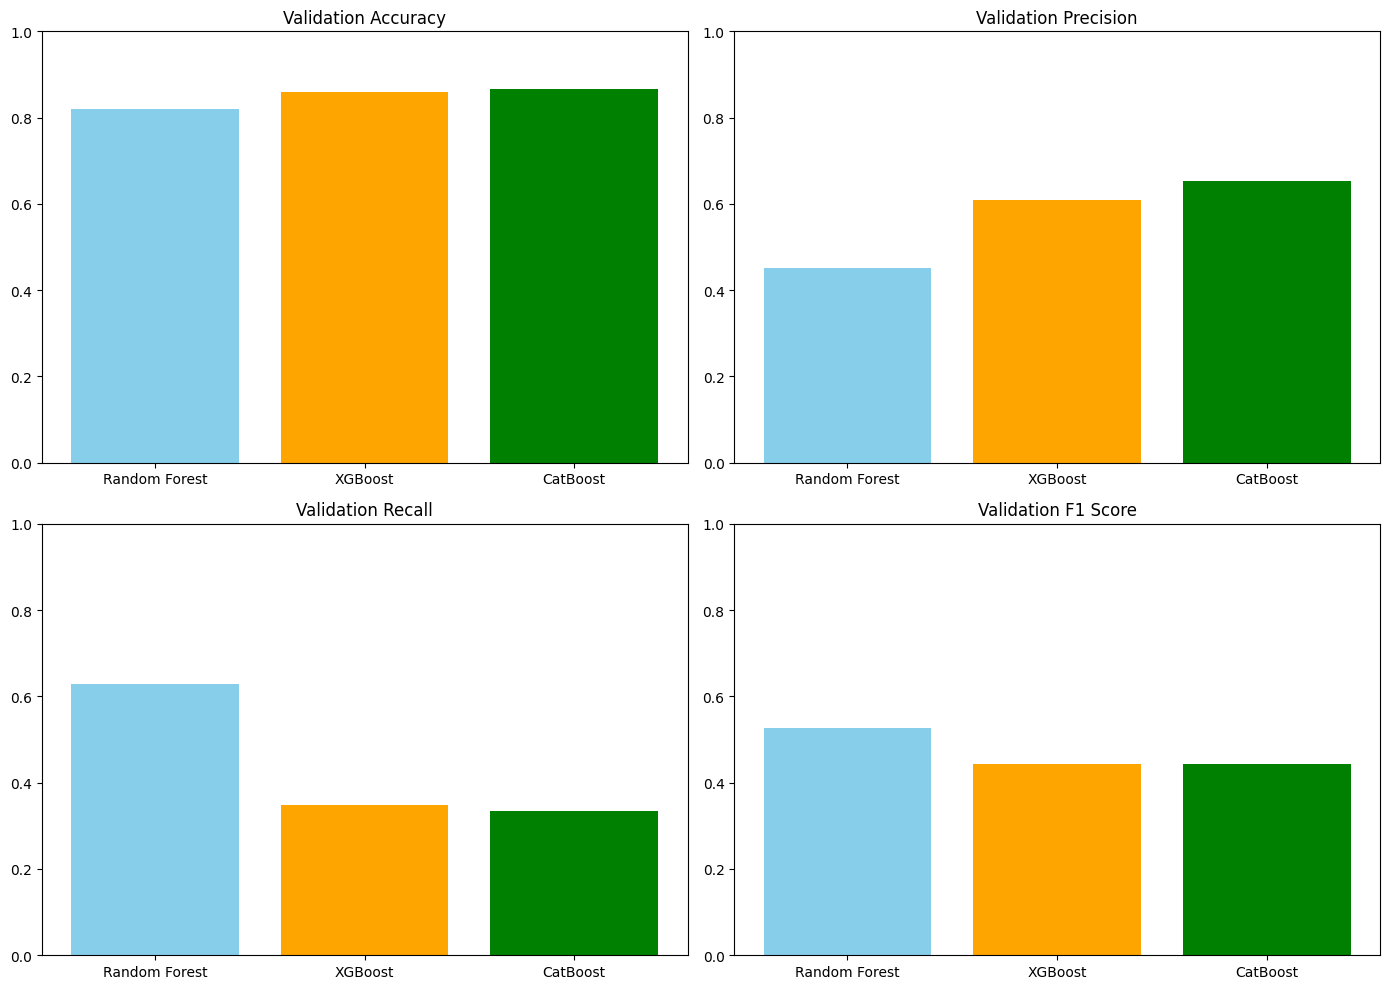

In [97]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Bar plot for Validation Accuracy
axes[0, 0].bar(df_results['Model'], df_results['Validation Accuracy'], color=['skyblue', 'orange', 'green'])
axes[0, 0].set_title('Validation Accuracy')
axes[0, 0].set_ylim(0, 1)

# Bar plot for Validation Precision
axes[0, 1].bar(df_results['Model'], df_results['Validation Precision'], color=['skyblue', 'orange', 'green'])
axes[0, 1].set_title('Validation Precision')
axes[0, 1].set_ylim(0, 1)

# Bar plot for Validation Recall
axes[1, 0].bar(df_results['Model'], df_results['Validation Recall'], color=['skyblue', 'orange', 'green'])
axes[1, 0].set_title('Validation Recall')
axes[1, 0].set_ylim(0, 1)

# Bar plot for Validation F1 Score
axes[1, 1].bar(df_results['Model'], df_results['Validation F1 Score'], color=['skyblue', 'orange', 'green'])
axes[1, 1].set_title('Validation F1 Score')
axes[1, 1].set_ylim(0, 1)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [96]:
# Display with pandas styler for better formatting (if in a Jupyter notebook)
df_results.style.set_caption("Model Performance Comparison")

In [81]:
import joblib

# Save the final model
joblib.dump(rf_best, 'final_rf_model.pkl')

['final_rf_model.pkl']

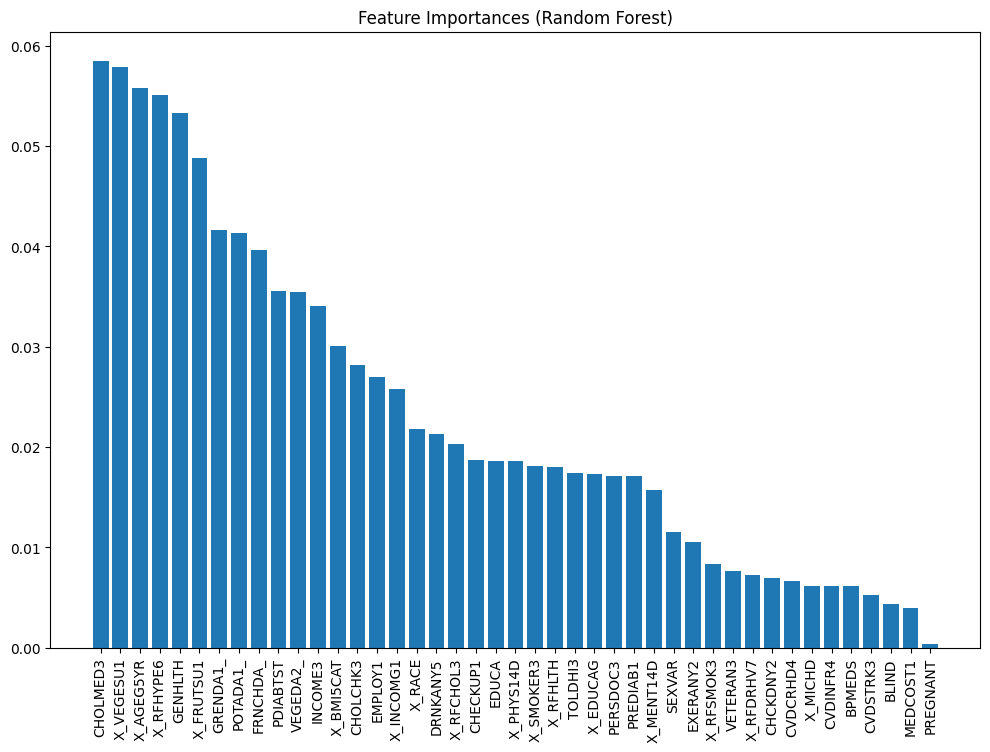

In [76]:
# Feature importance for the final Random Forest model
import matplotlib.pyplot as plt
import numpy as np

importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.show()

In [84]:
import numpy as np

# Fine-tune threshold for best trade-off between precision and recall
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds:
    y_test_pred_rf_adjusted = (y_test_probs_rf >= threshold).astype(int)
    f1 = f1_score(y_test, y_test_pred_rf_adjusted)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print("Best Threshold:", best_threshold)
print("Best F1-Score:", best_f1)

Best Threshold: 0.2599999999999999
Best F1-Score: 0.5285285285285285


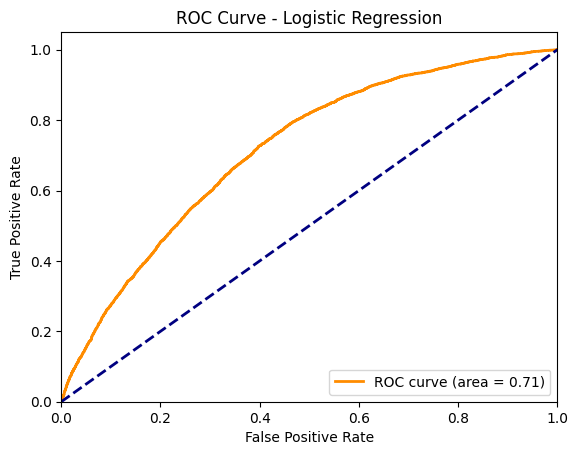

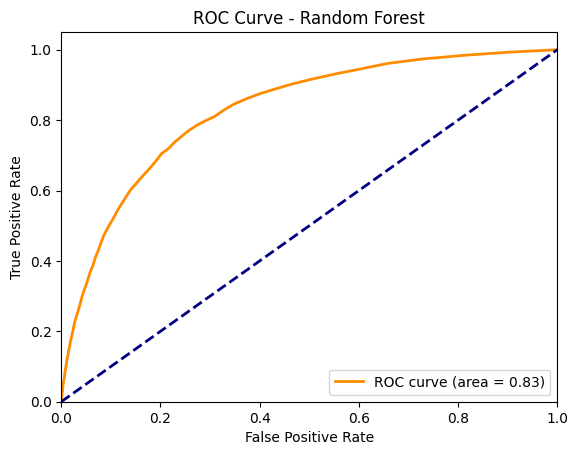

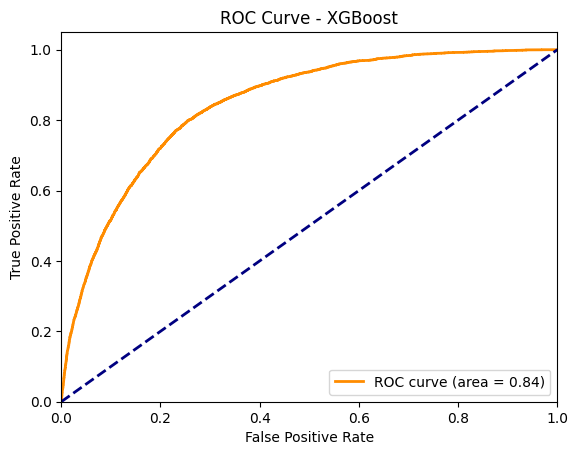

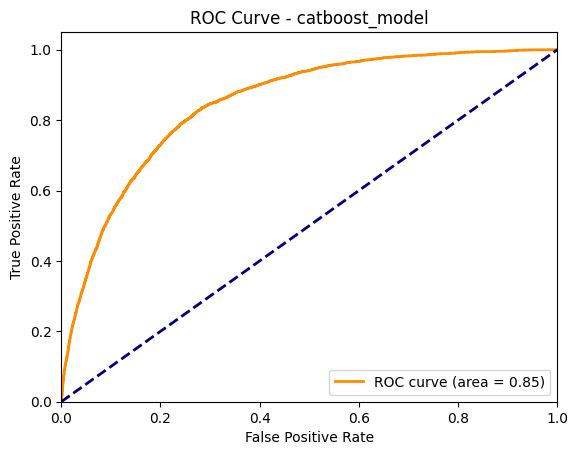

In [180]:
# Function to plot ROC Curve
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Logistic Regression ROC
plot_roc_curve(y_val, logreg.predict_proba(X_val)[:, 1], "Logistic Regression")

# Random Forest ROC
plot_roc_curve(y_val, rf.predict_proba(X_val)[:, 1], "Random Forest")

# XGBoost ROC
plot_roc_curve(y_val, xgb.predict_proba(X_val)[:, 1], "XGBoost")

# catboost_model  ROC
plot_roc_curve(y_val, catboost_model.predict_proba(X_val)[:, 1], "catboost_model")


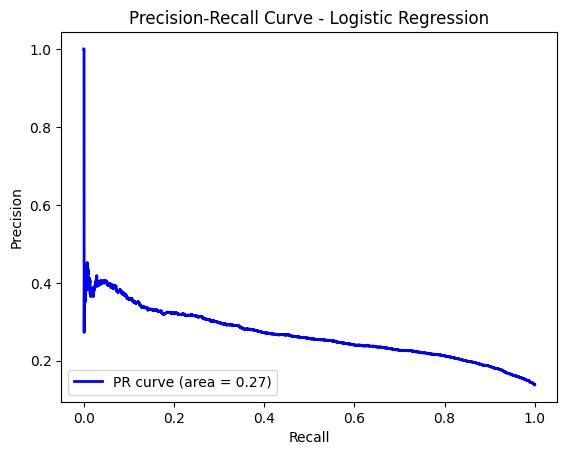

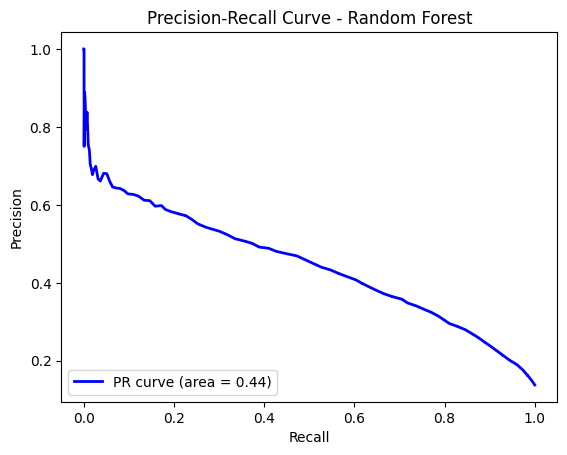

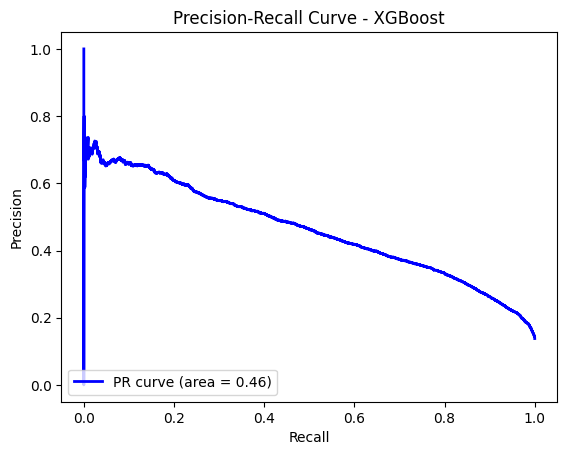

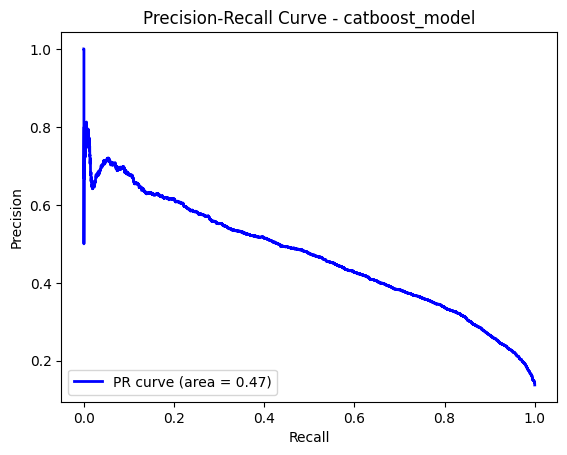

In [181]:
# Function to plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_pred_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.show()

# Logistic Regression PR
plot_precision_recall_curve(y_val, logreg.predict_proba(X_val)[:, 1], "Logistic Regression")

# Random Forest PR
plot_precision_recall_curve(y_val, rf.predict_proba(X_val)[:, 1], "Random Forest")

# XGBoost PR
plot_precision_recall_curve(y_val, xgb.predict_proba(X_val)[:, 1], "XGBoost")

# catboost_model
plot_precision_recall_curve(y_val, catboost_model.predict_proba(X_val)[:, 1], "catboost_model")


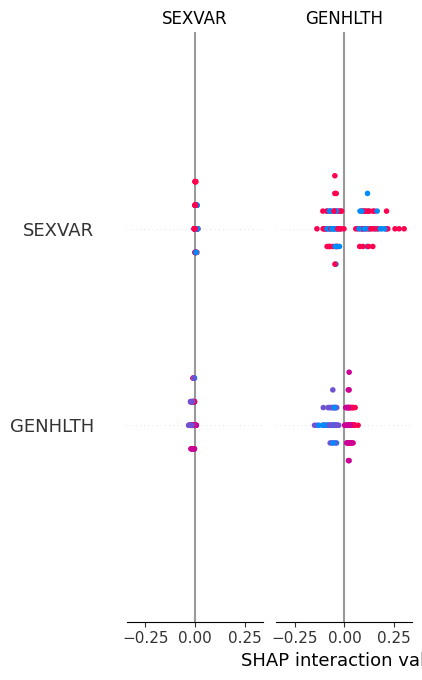

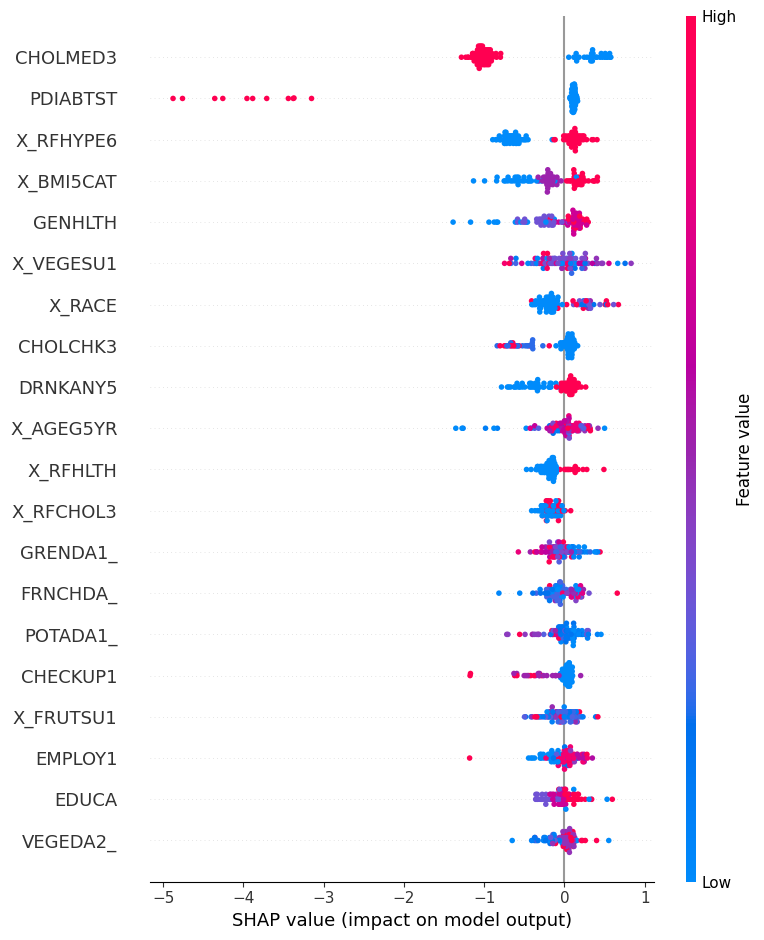

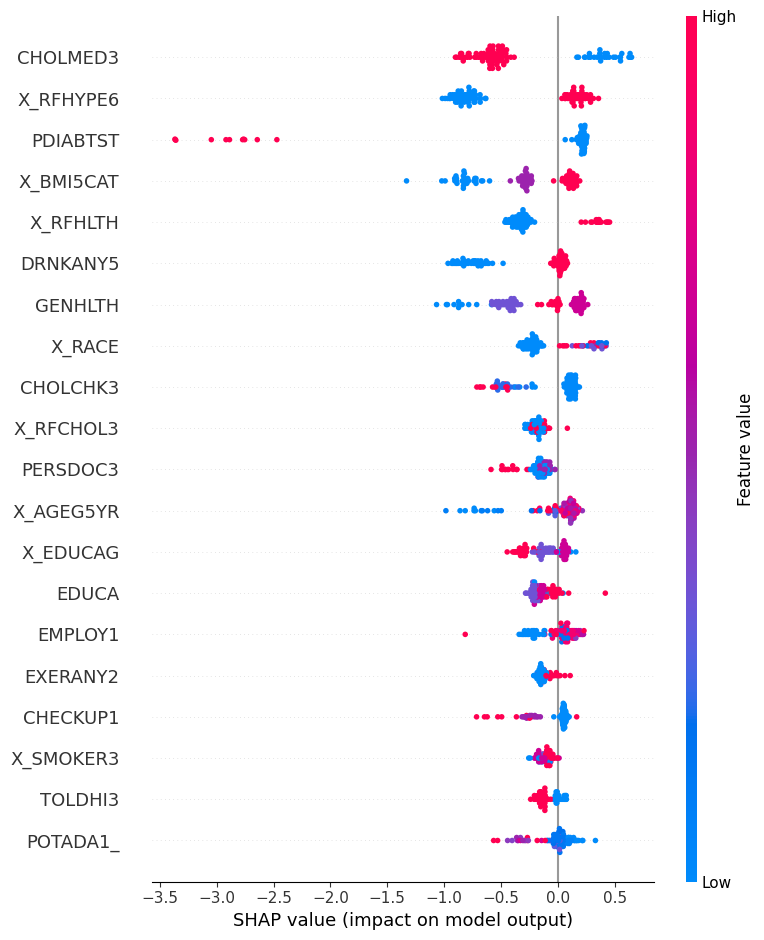

In [107]:
import shap
import matplotlib.pyplot as plt

X_val_subset = X_val.sample(n=100, random_state=42)  # Adjust the number as needed
explainer_rf = shap.TreeExplainer(rf_best)  # For Random Forest
explainer_xgb = shap.TreeExplainer(xgb)  # For XGBoost
explainer_cat = shap.TreeExplainer(catboost_model)  # For CatBoost

# Example for Random Forest
shap_values_rf = explainer_rf.shap_values(X_val_subset)

# Example for XGBoost
shap_values_xgb = explainer_xgb.shap_values(X_val_subset)

# Example for CatBoost
shap_values_cat = explainer_cat.shap_values(X_val_subset)
# Random Forest
shap.summary_plot(shap_values_rf, X_val_subset, feature_names=X_val.columns)

# XGBoost
shap.summary_plot(shap_values_xgb, X_val_subset, feature_names=X_val.columns)

# CatBoost
shap.summary_plot(shap_values_cat, X_val_subset, feature_names=X_val.columns)
